In [ ]:
import numpy as np
import pandas as pd
from math import sqrt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL

from sktime.forecasting.ets import AutoETS
from sktime.forecasting.base import ForecastingHorizon

from data.ex_data import get_sea_surface_temp
from utils import *


In [ ]:
def make_idx(n, start="2000-01-31", freq="M"):
    return pd.date_range(start, periods=n, freq=freq)  # month-end

def sim_level_only_rw(n=300, sigma=1.0, seed=0):
    rng = np.random.default_rng(seed)
    y = np.cumsum(rng.normal(0, sigma, n))
    return pd.Series(y, index=make_idx(n))

def sim_trend(n=300, drift=0.05, sigma=1.0, seed=0):
    rng = np.random.default_rng(seed)
    y = np.cumsum(drift + rng.normal(0, sigma, n))
    return pd.Series(y, index=make_idx(n))

def sim_trend_season_add(n=240, drift=0.05, amp=5.0, P=12, sigma=1.0, seed=0):
    rng = np.random.default_rng(seed)
    t = np.arange(n)
    season = amp * np.sin(2 * np.pi * t / P)
    y = 20 + drift * t + season + rng.normal(0, sigma, n)
    return pd.Series(y, index=make_idx(n))

def sim_multiplicative(n=240, drift=0.1, amp=0.15, P=12, rel_sigma=0.03, seed=0):
    rng = np.random.default_rng(seed)
    t = np.arange(n)
    level = 50 + drift * t
    season = 1 + amp * np.sin(2 * np.pi * t / P)
    y = level * season * (1 + rng.normal(0, rel_sigma, n))
    return pd.Series(y, index=make_idx(n))


In [ ]:
# helpers
def _to_timestamp_index(s):
    if s is None:
        return None
    if isinstance(s.index, pd.PeriodIndex):
        s = s.copy()
        s.index = s.index.to_timestamp("M")
    return s

def _to_timestamp_x(x):
    return x.to_timestamp("M") if isinstance(x, pd.PeriodIndex) else x

ETS_GRID = [
    dict(error="add", trend=None,  seasonal=None,  sp=12, label="ETS(A,N,N)"),
    dict(error="add", trend="add", seasonal=None,  sp=12, label="ETS(A,A,N)"),
    dict(error="add", trend="add", seasonal="add", sp=12, label="ETS(A,A,A)"),
    dict(error="add", trend="add", seasonal=None,  damped_trend=True, sp=12, label="ETS(A,Ad,N)"),
    dict(error="mul", trend="add", seasonal="add", sp=12, label="ETS(M,A,A)"),
]

def ets_param_row(label, fitted):
    return {
        "model": label,
        "alpha": getattr(fitted, "smoothing_level", np.nan),
        "beta":  getattr(fitted, "smoothing_trend", np.nan),
        "gamma": getattr(fitted, "smoothing_seasonal", np.nan),
        "phi":   getattr(fitted, "damping_trend", np.nan),
        "AIC":   getattr(fitted, "aic", np.nan),
        "BIC":   getattr(fitted, "bic", np.nan),
    }

def run_synth_experiment(series, title, period=12):
    y = series.to_period("M")  # model on PeriodIndex
    train_size = int(0.8 * len(y))
    x_plot = _to_timestamp_x(y.index)

    # plot series + split
    fig, ax = time_plot(x_plot, y.values, label="y", title=title,
                        xlabel="Time", ylabel="Value", return_fig=True)
    ax.axvline(x_plot[train_size], color="gray", linestyle="--", label="Train/Test")
    ax.legend()
    fig.tight_layout()

    rows = []
    for cfg in ETS_GRID:
        if cfg["error"] == "mul" and (y <= 0).any():
            continue

        model = AutoETS(
            error=cfg["error"],
            trend=cfg.get("trend", None),
            seasonal=cfg.get("seasonal", None),
            sp=period,
            damped_trend=cfg.get("damped_trend", False),
            auto=False,
        )

        fitted_values, pred, interval = fit_and_forecast(model, y, train_size)

        fitted_values = _to_timestamp_index(fitted_values)
        pred = _to_timestamp_index(pred)
        if interval is not None and isinstance(interval.index, pd.PeriodIndex):
            interval = interval.copy()
            interval.index = interval.index.to_timestamp("M")

        fig, ax = time_plot(x_plot, y.values, label="Data", title=cfg["label"],
                            xlabel="Time", ylabel="Value", return_fig=True)
        ax.axvline(x_plot[train_size], color="gray", linestyle="--")
        plot_fit_and_forecast(ax, fitted_values, pred, interval, model_name=cfg["label"])
        ax.legend()
        fig.tight_layout()

        f = model._fitted_forecaster
        rows.append(ets_param_row(cfg["label"], f))

        resid = np.asarray(f.resid)
        std = (resid - resid.mean()) / (resid.std(ddof=1) + 1e-12)
        residual_analysis_plots(std)

    return pd.DataFrame(rows).sort_values("AIC")


## synthetic experiments

/var/folders/4b/26rq547d04x8qvf8fylq7n0c0000gn/T/ipykernel_63723/2401865667.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return pd.date_range(start, periods=n, freq=freq)  # month-end


model     alpha      beta     gamma  phi         AIC         BIC
0   ETS(A,N,N)  0.868478       NaN       NaN  NaN  645.780666  656.222582
1   ETS(A,A,N)  0.840264  0.000084       NaN  NaN  645.954240  663.357435
3  ETS(A,Ad,N)  0.867901  0.000087       NaN  0.8  651.378419  672.262252
2   ETS(A,A,A)  0.849345  0.000085  0.000015  NaN  658.999713  721.651214

/var/folders/4b/26rq547d04x8qvf8fylq7n0c0000gn/T/ipykernel_63723/2401865667.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return pd.date_range(start, periods=n, freq=freq)  # month-end


model     alpha      beta     gamma   phi         AIC         BIC
0   ETS(A,N,N)  0.912562       NaN       NaN   NaN  688.111078  698.552995
1   ETS(A,A,N)  0.908175  0.000091       NaN   NaN  691.370520  708.773714
3  ETS(A,Ad,N)  0.909722  0.000091       NaN  0.98  693.659484  714.543317
2   ETS(A,A,A)  0.912467  0.000091  0.000009   NaN  709.887130  772.538631

/var/folders/4b/26rq547d04x8qvf8fylq7n0c0000gn/T/ipykernel_63723/2401865667.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return pd.date_range(start, periods=n, freq=freq)  # month-end
/Users/hslu-n0007794/Documents/HS25/TIME/TIME_exercises_NadineFlück_MaraEckart/notebooks/utils.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, **kwargs)


model   alpha          beta   gamma       phi         AIC         BIC
2   ETS(A,A,A)  0.0001  1.000000e-08  0.0001       NaN  586.189586  644.824502
4   ETS(M,A,A)  0.0001  1.000000e-08  0.0001       NaN  609.810760  668.445677
0   ETS(A,N,N)  0.9999           NaN     NaN       NaN  876.508219  886.280705
1   ETS(A,A,N)  0.9999  9.999000e-05     NaN       NaN  880.492202  896.779679
3  ETS(A,Ad,N)  0.9999  9.999000e-05     NaN  0.866098  882.485408  902.030381

/var/folders/4b/26rq547d04x8qvf8fylq7n0c0000gn/T/ipykernel_63723/2401865667.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return pd.date_range(start, periods=n, freq=freq)  # month-end


model     alpha          beta   gamma  phi          AIC          BIC
4   ETS(M,A,A)  0.000100  1.000000e-08  0.0001  NaN   809.090326   867.725242
2   ETS(A,A,A)  0.000100  1.000000e-08  0.0001  NaN   817.597635   876.232551
0   ETS(A,N,N)  0.999900           NaN     NaN  NaN  1101.273323  1111.045810
1   ETS(A,A,N)  0.737477  7.374035e-01     NaN  NaN  1106.199194  1122.486671
3  ETS(A,Ad,N)  0.999900  9.999000e-05     NaN  0.8  1106.837624  1126.382596

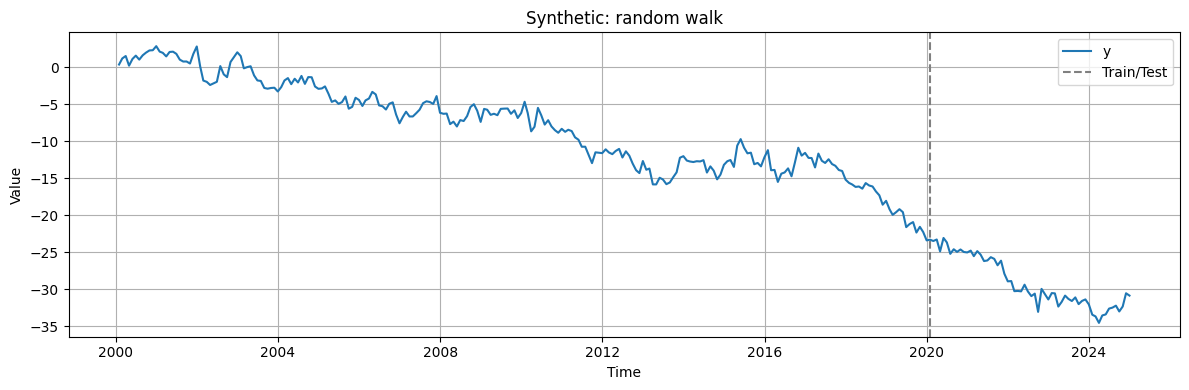

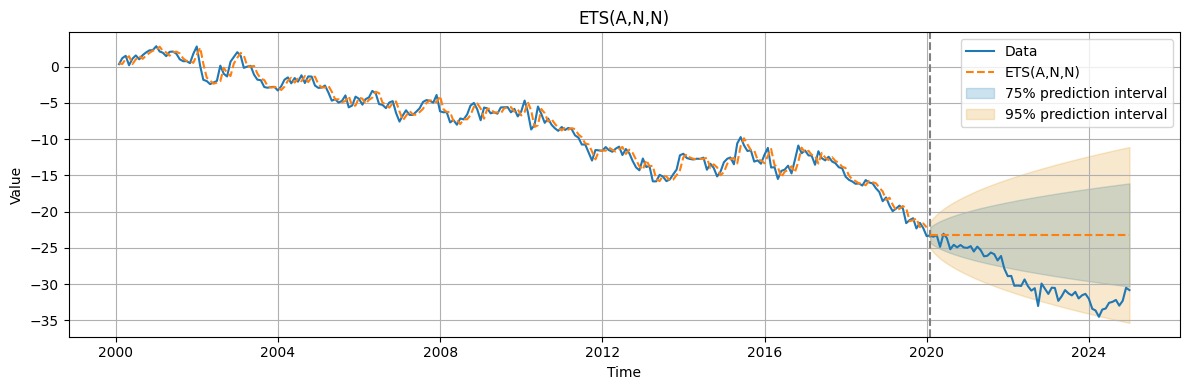

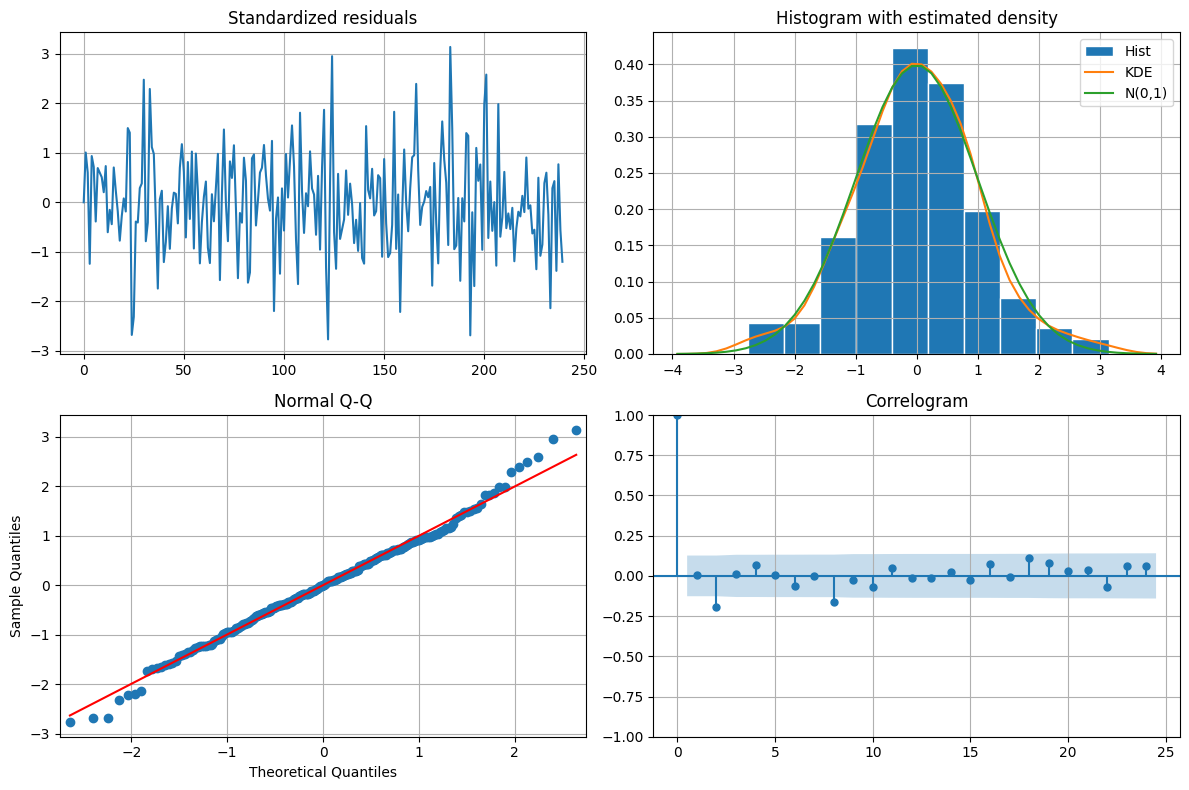

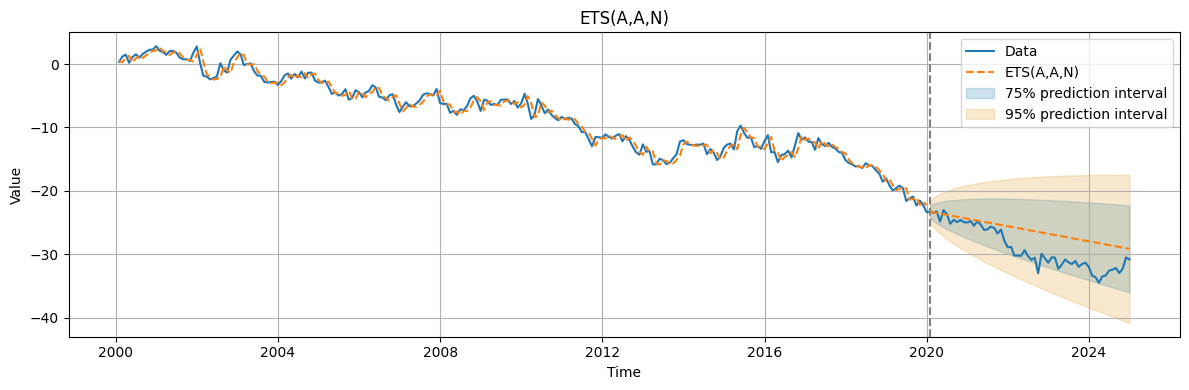

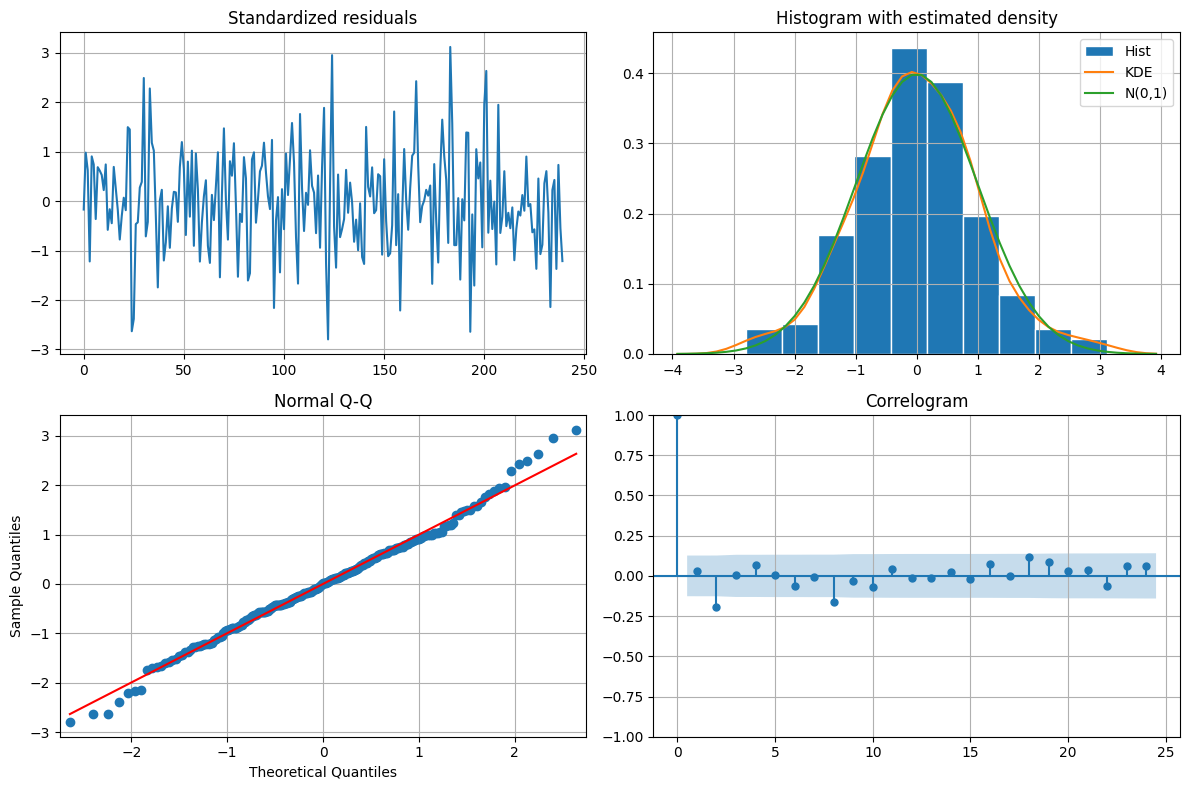

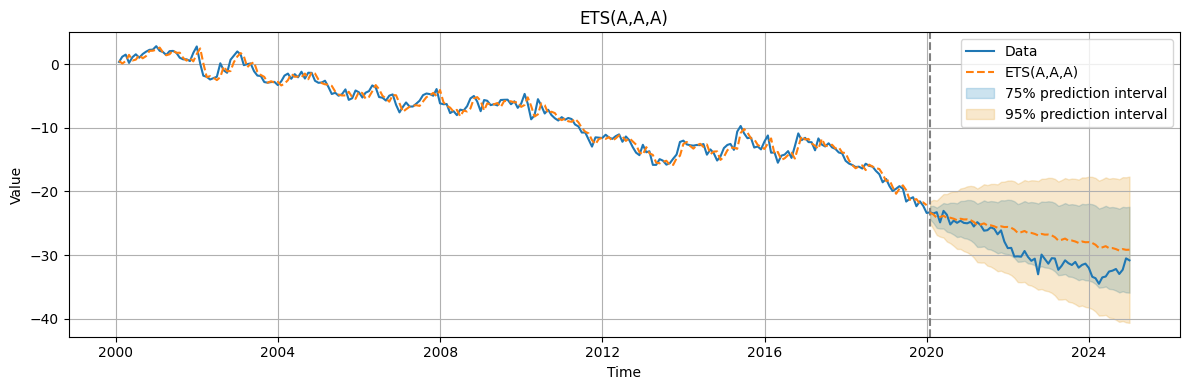

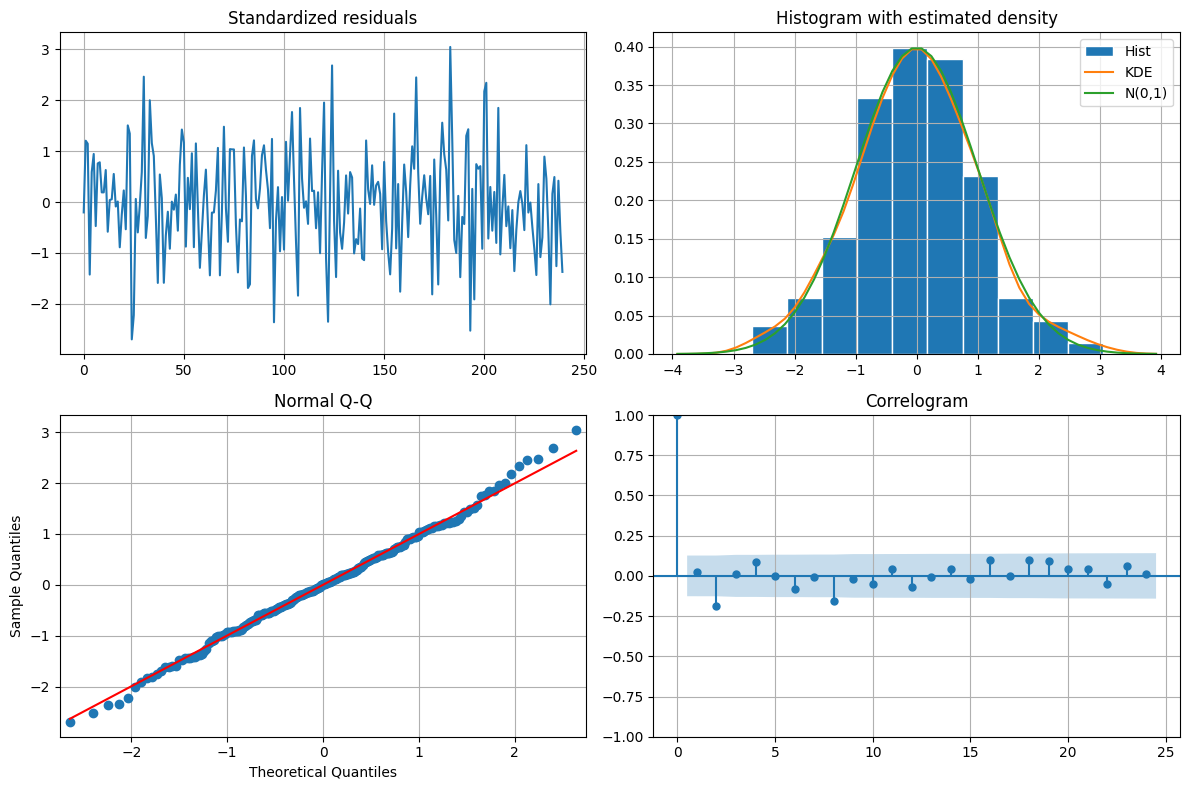

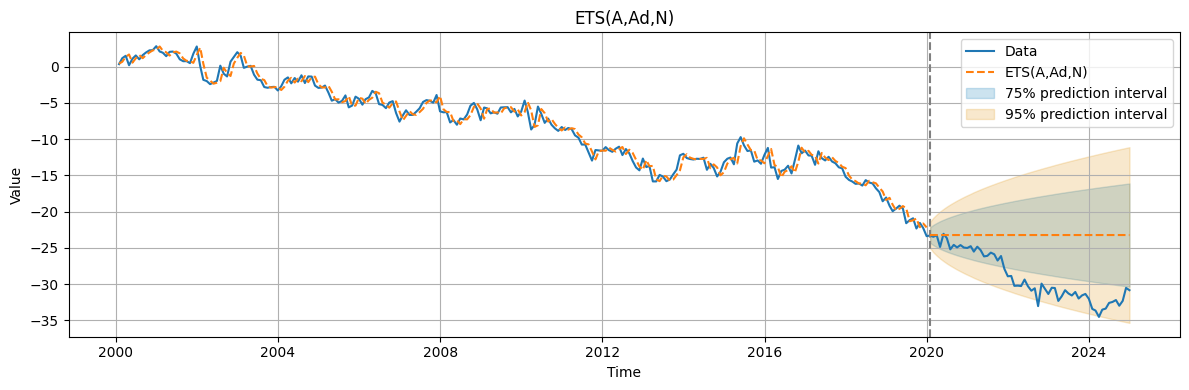

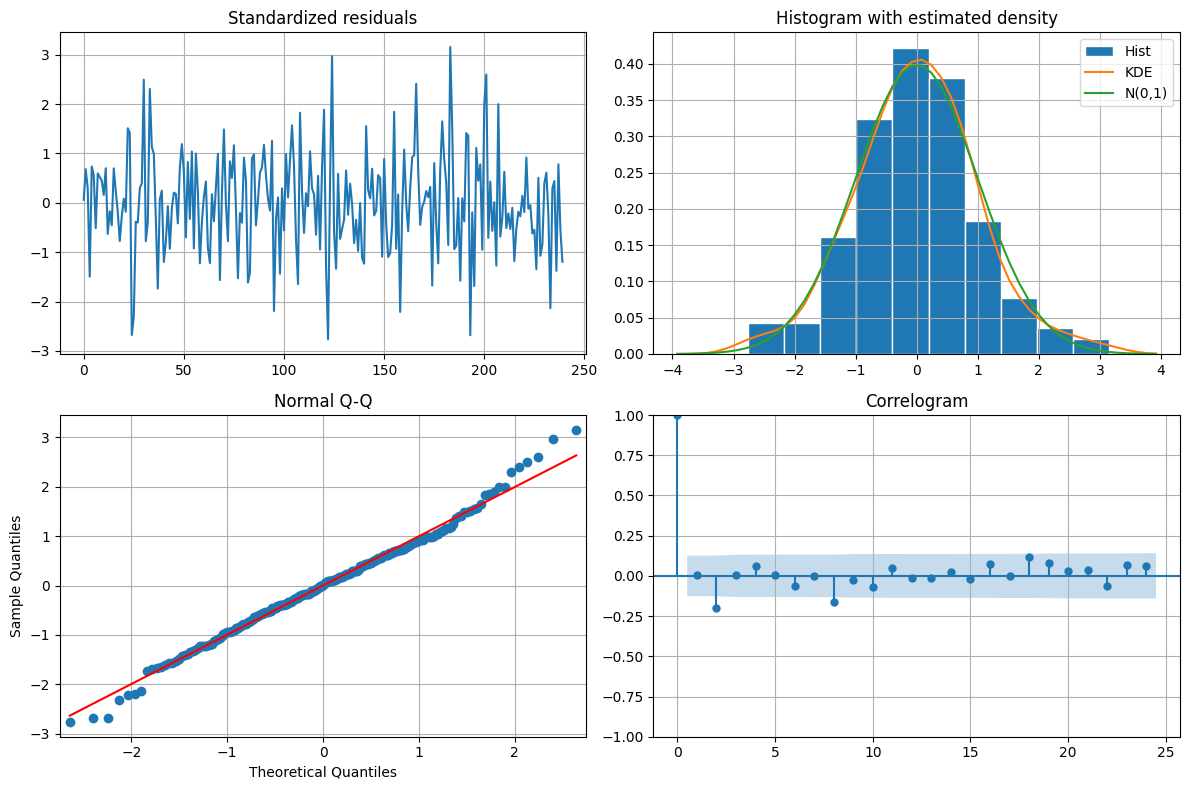

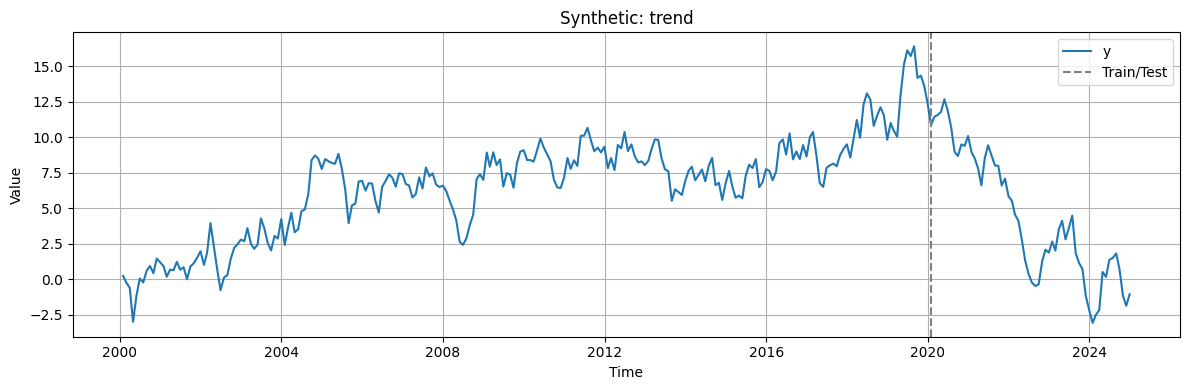

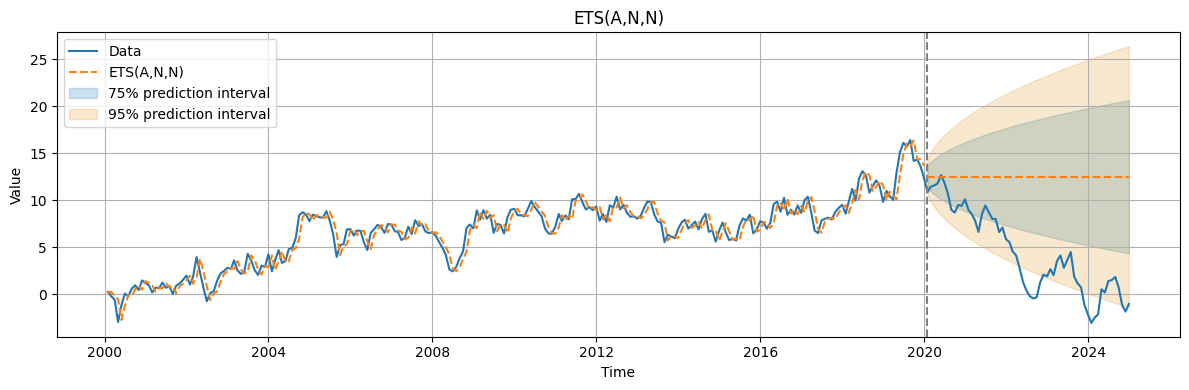

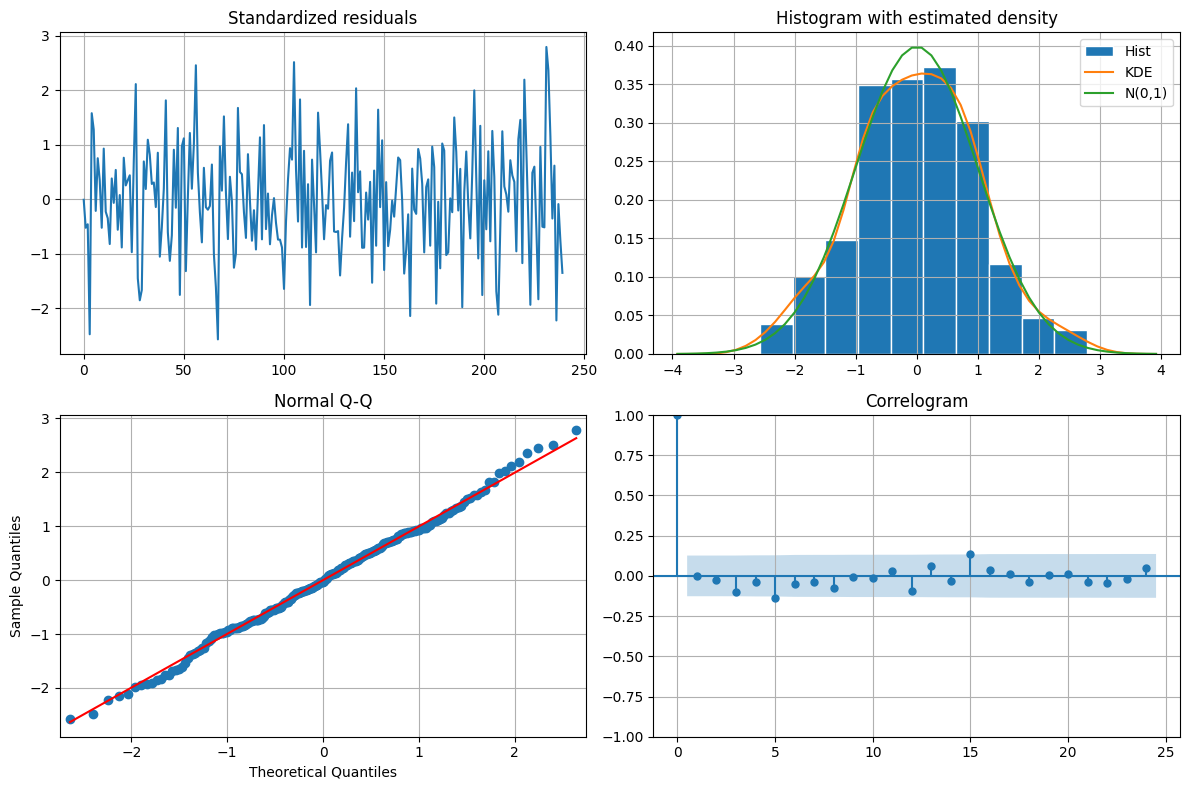

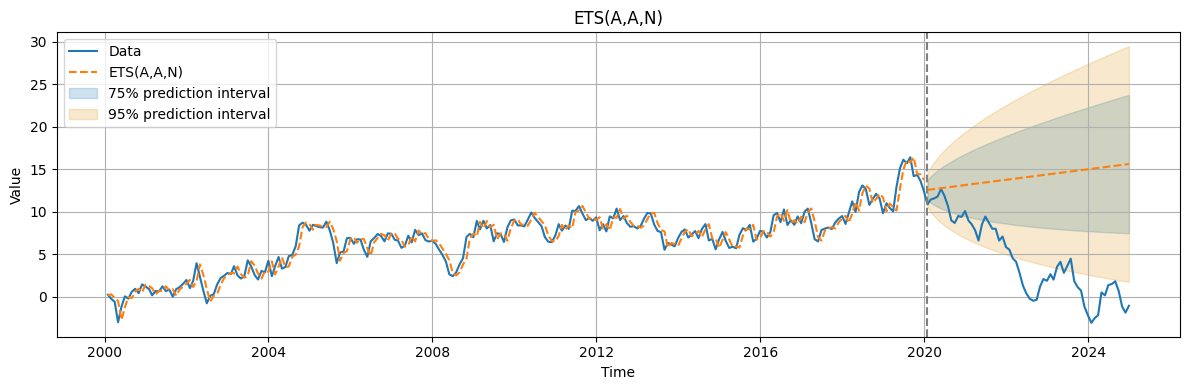

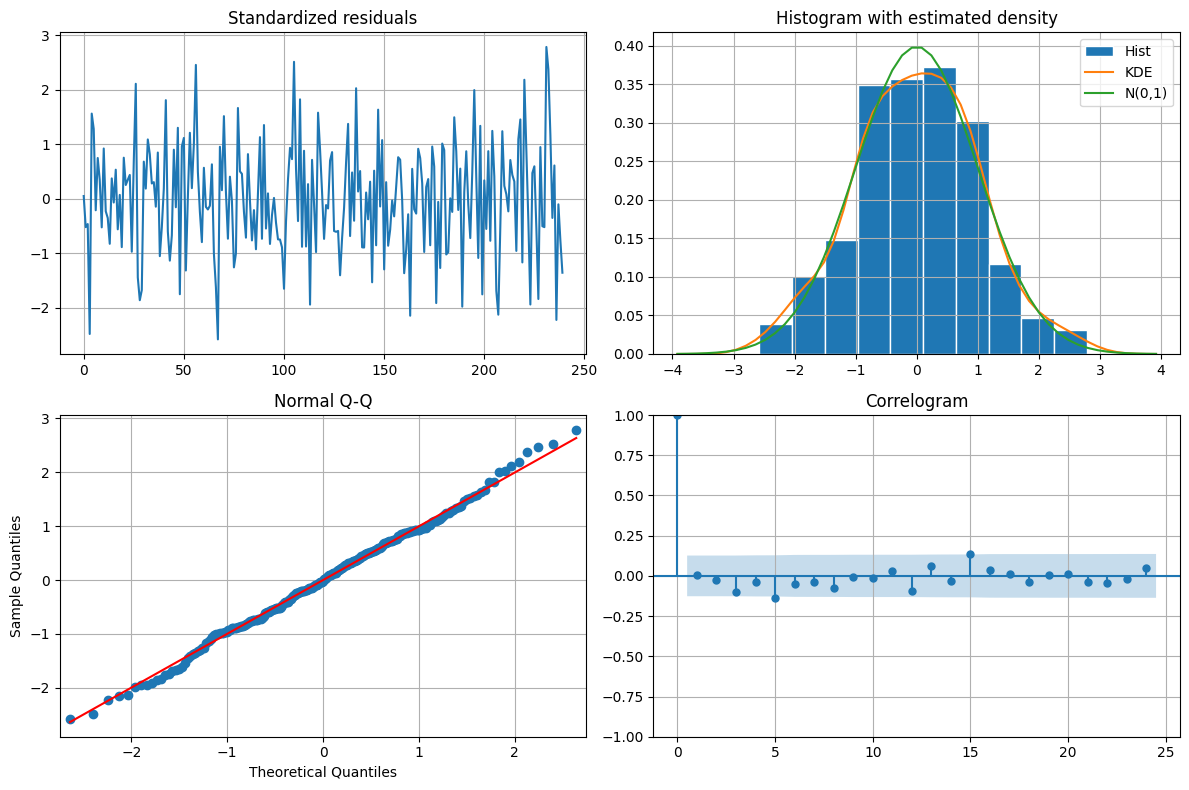

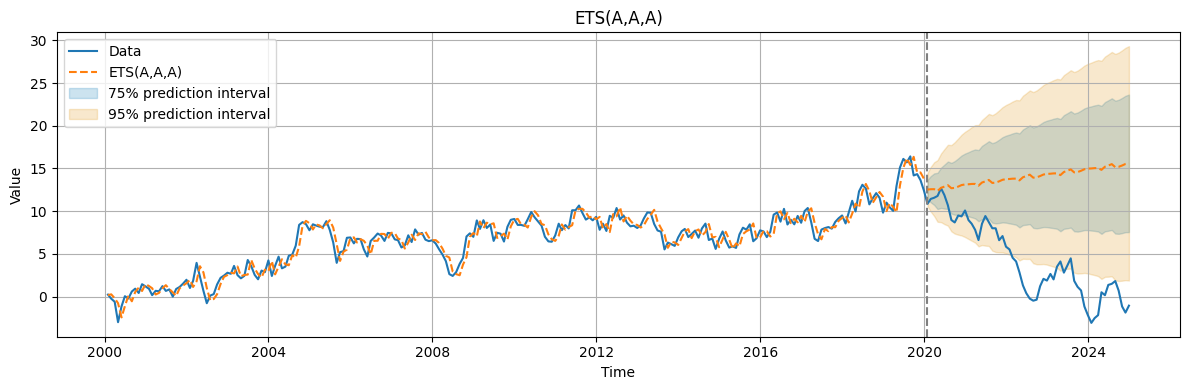

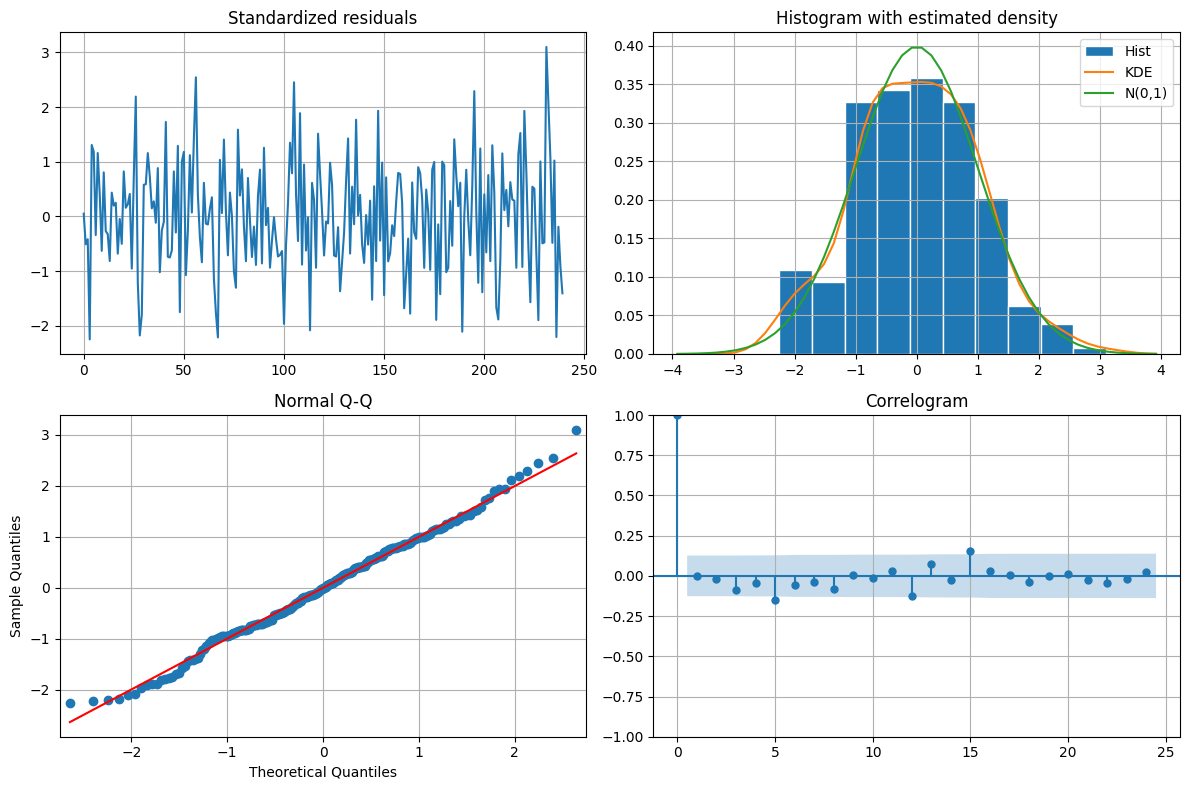

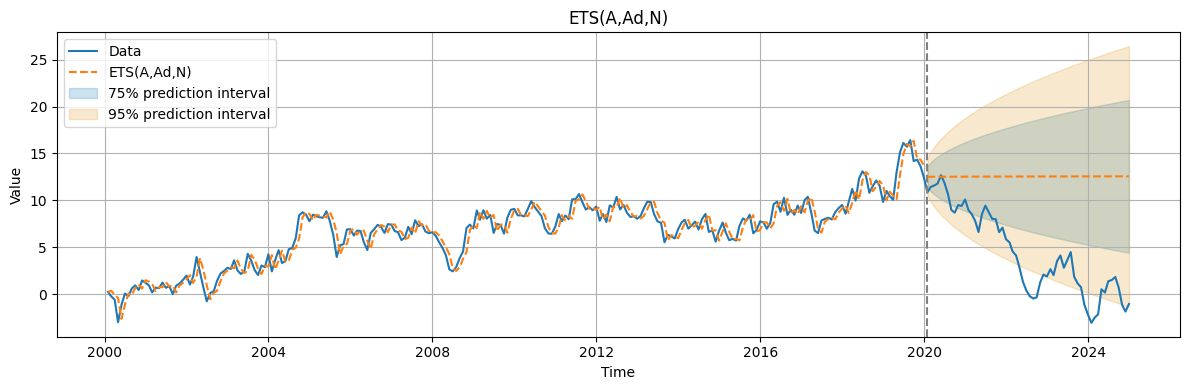

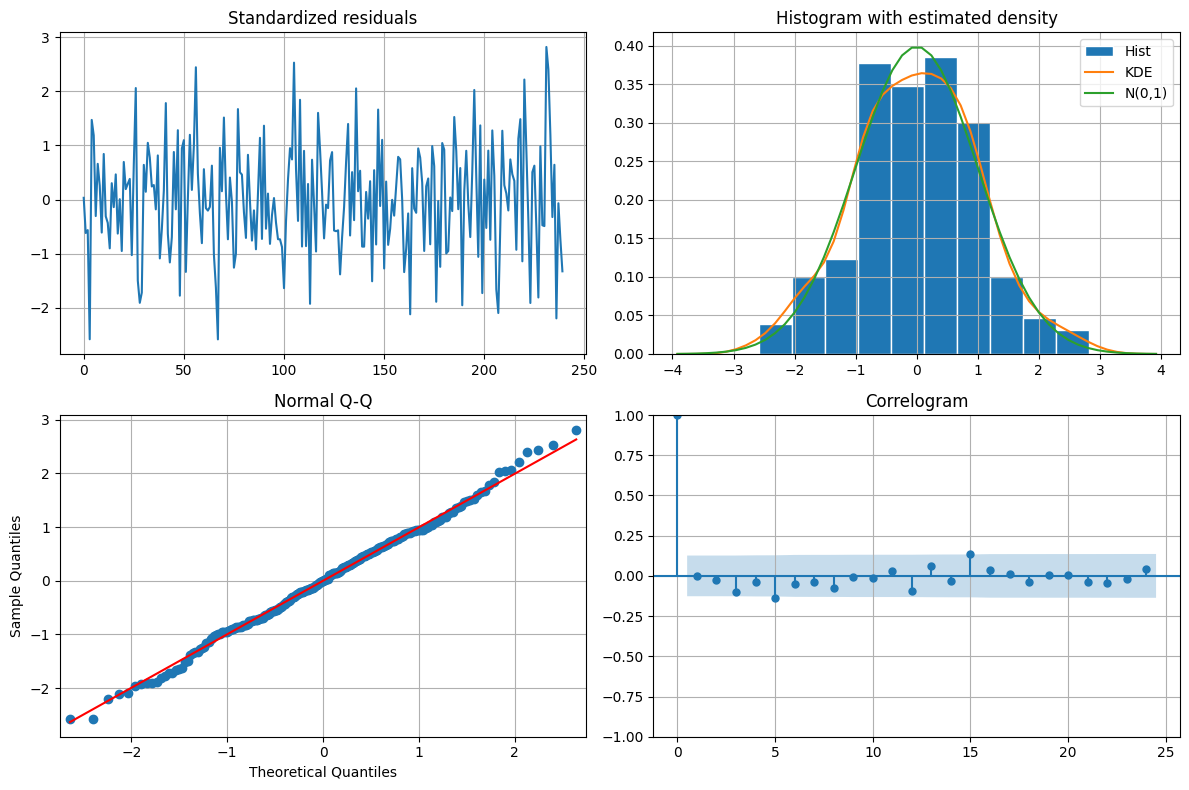

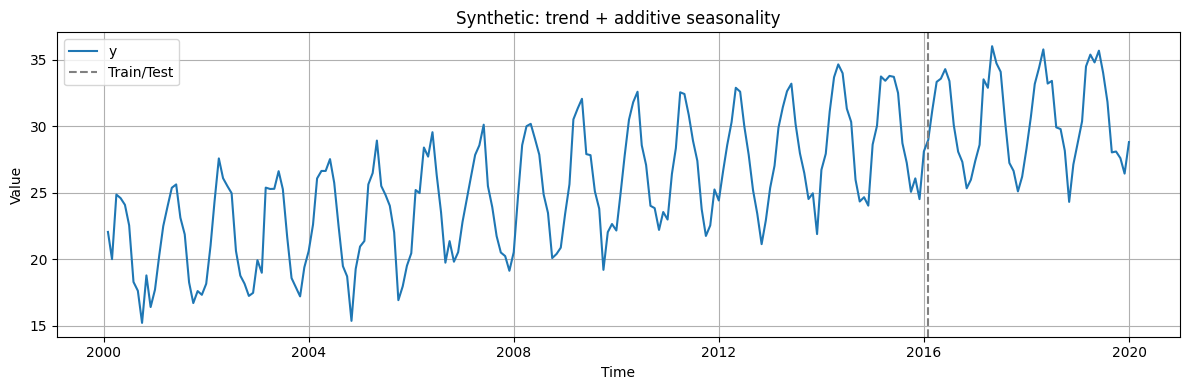

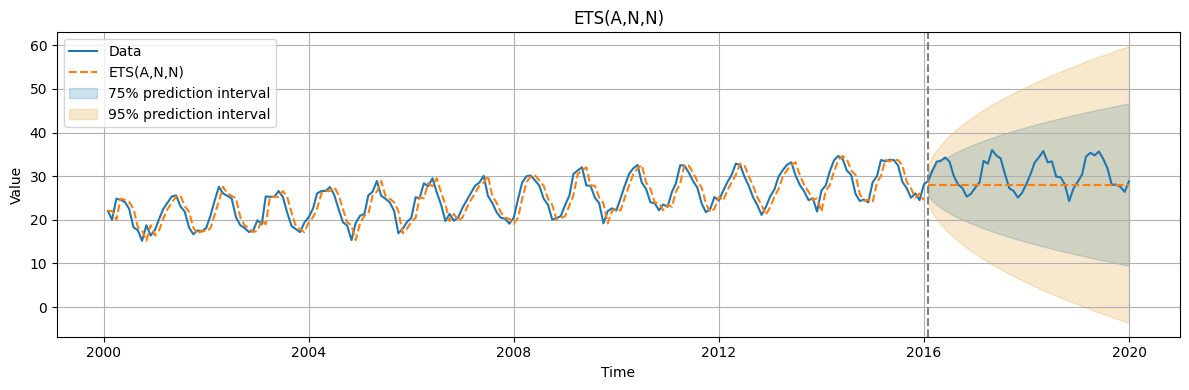

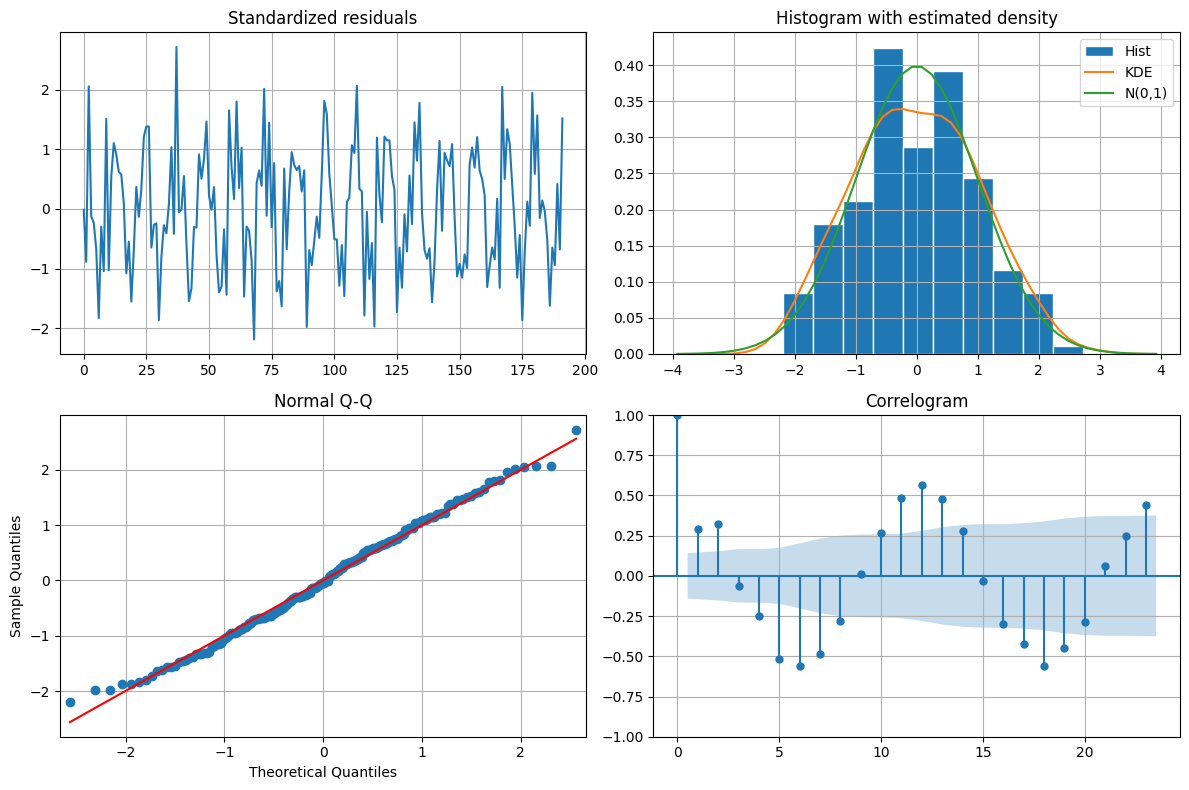

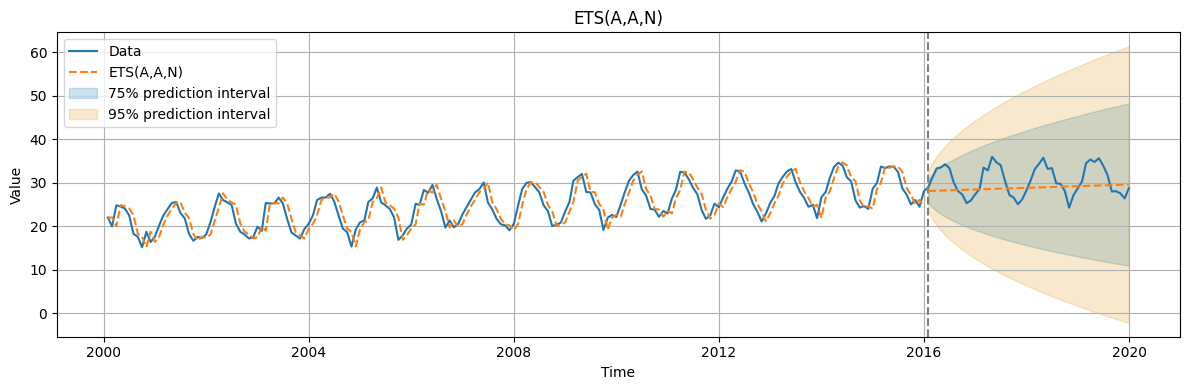

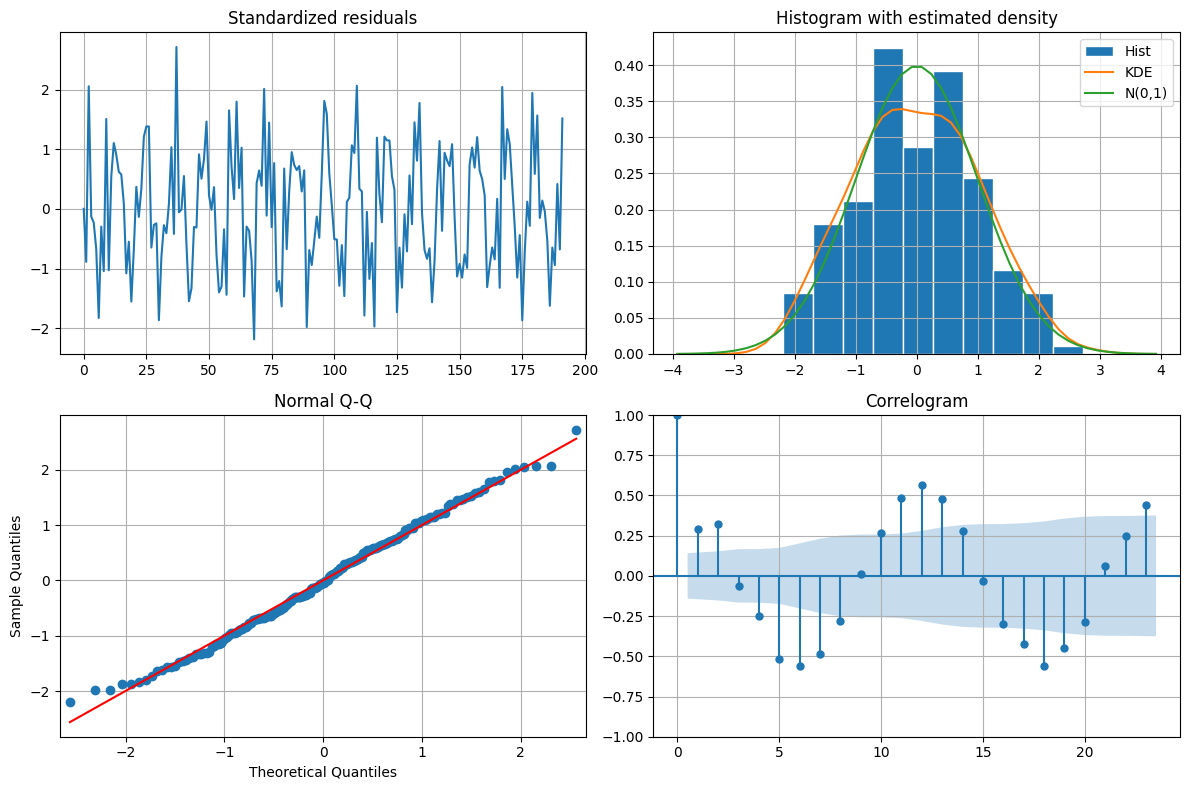

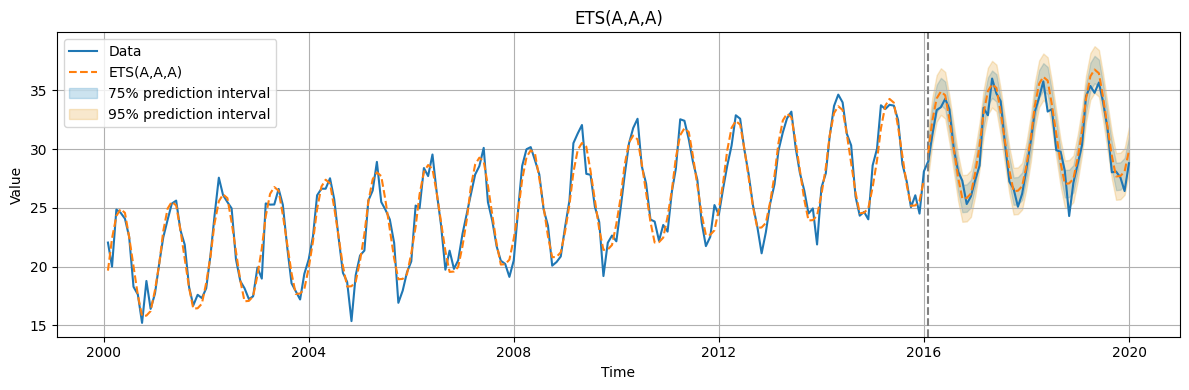

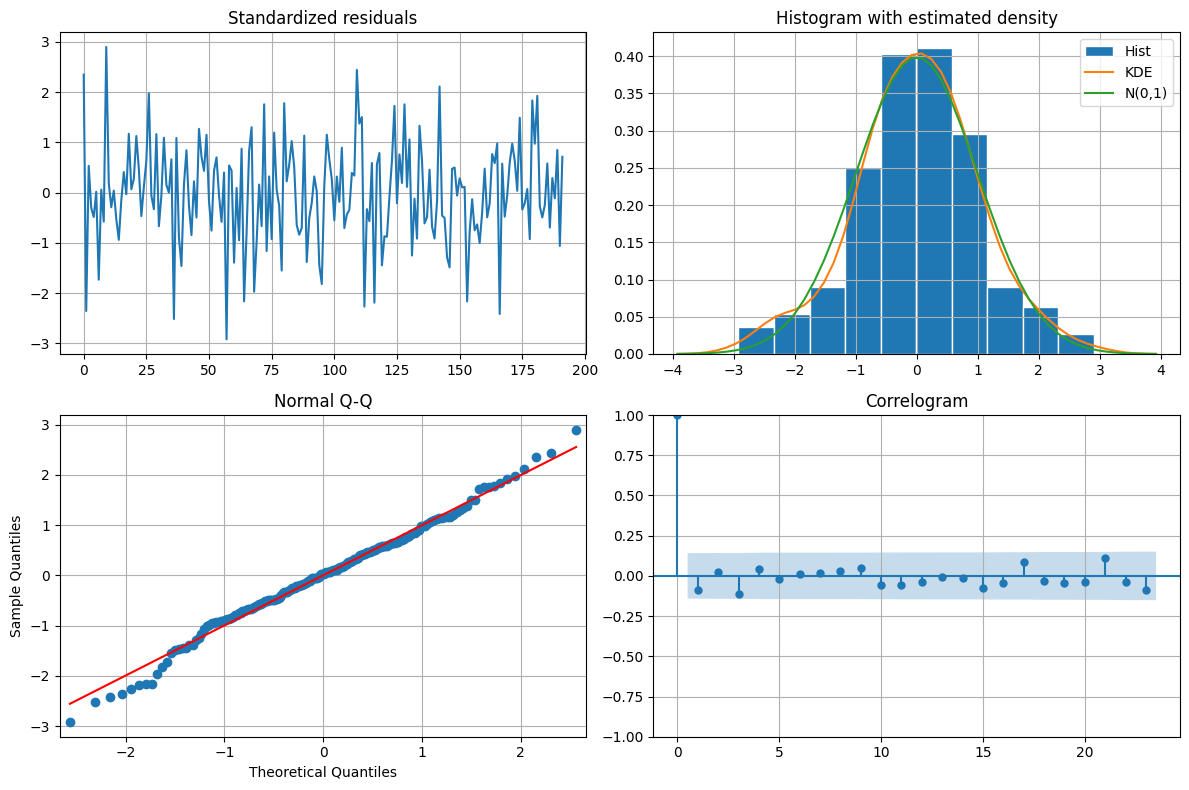

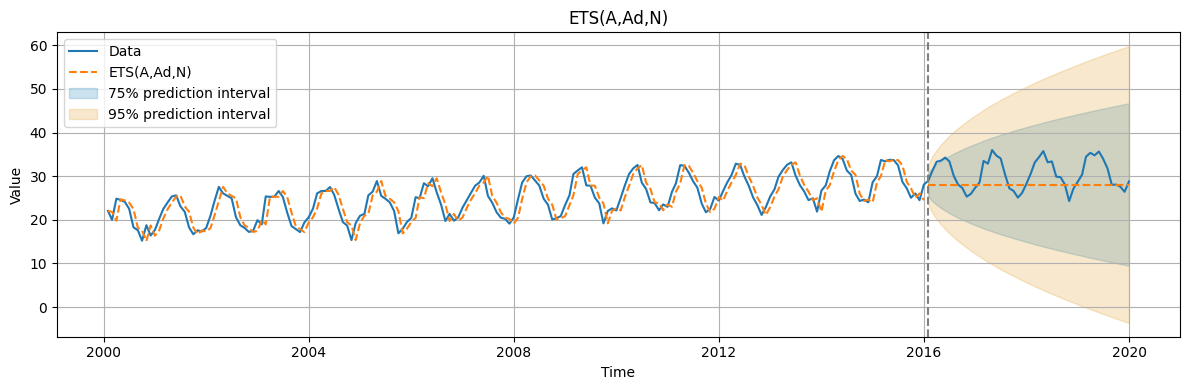

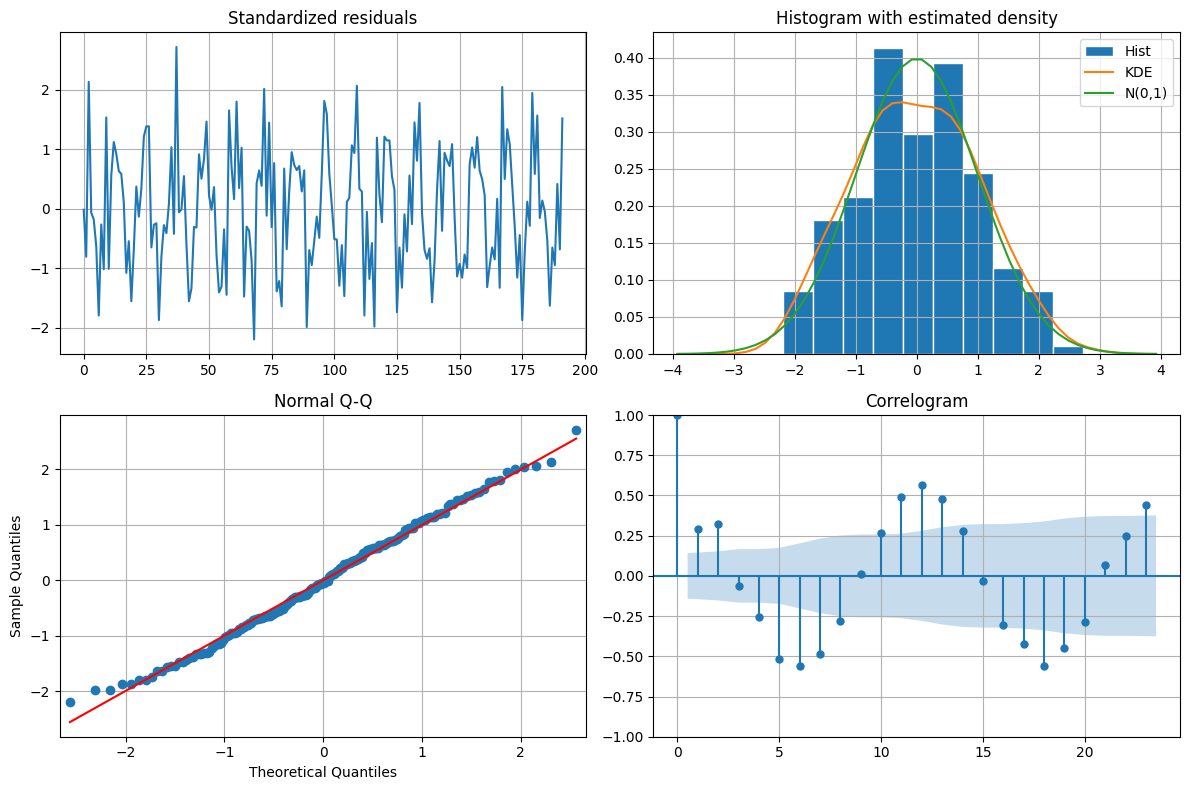

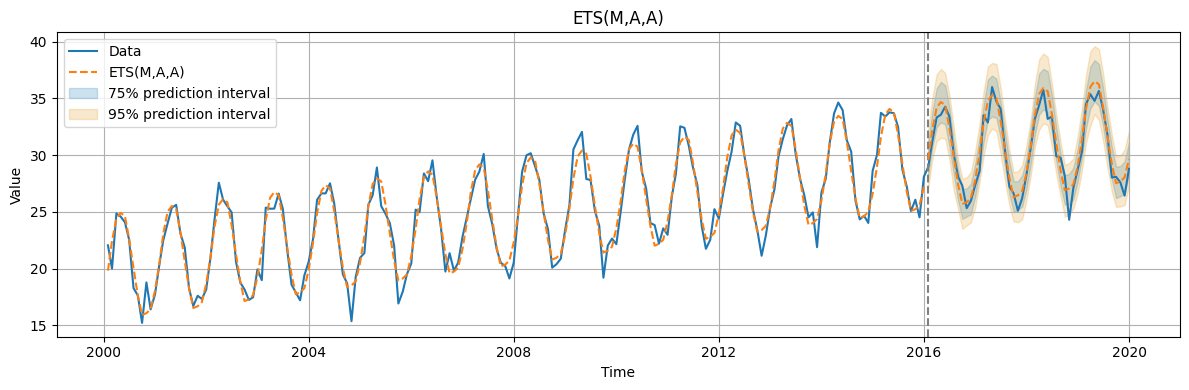

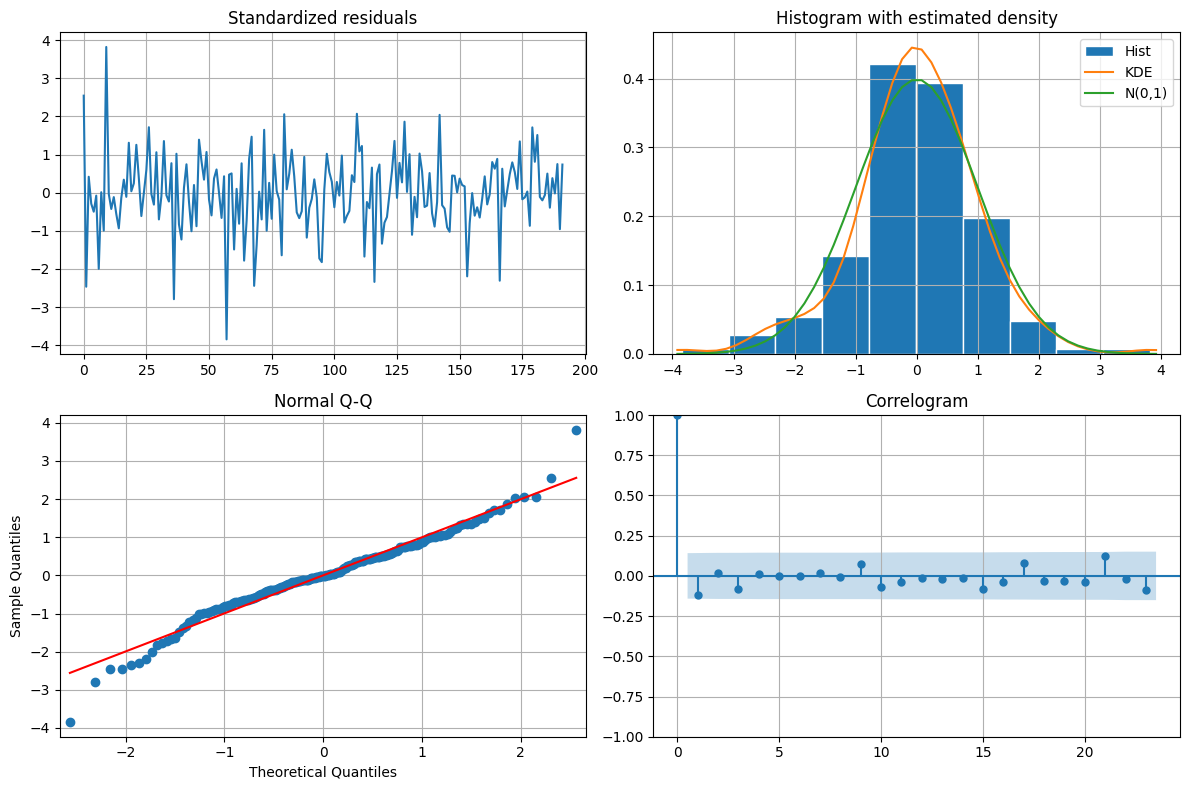

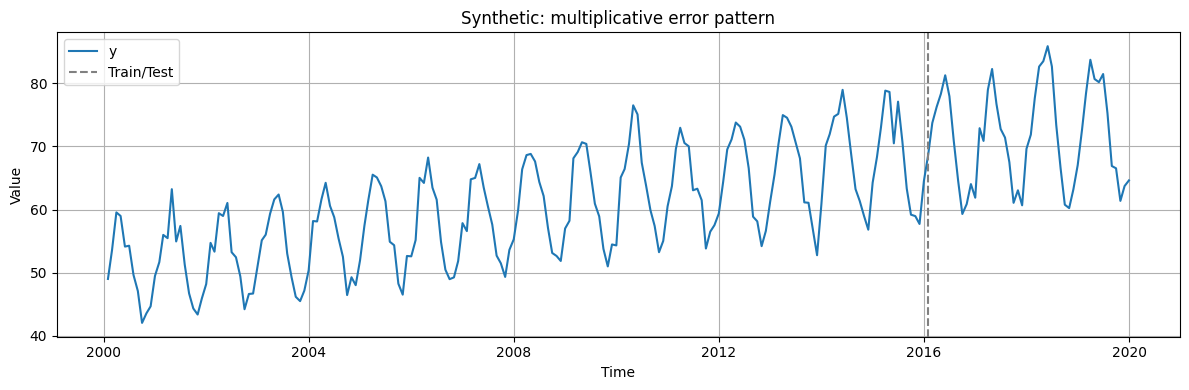

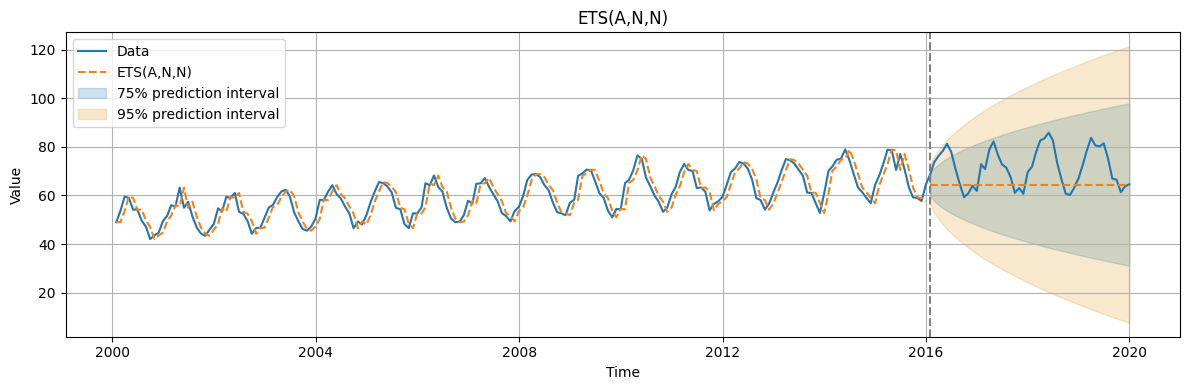

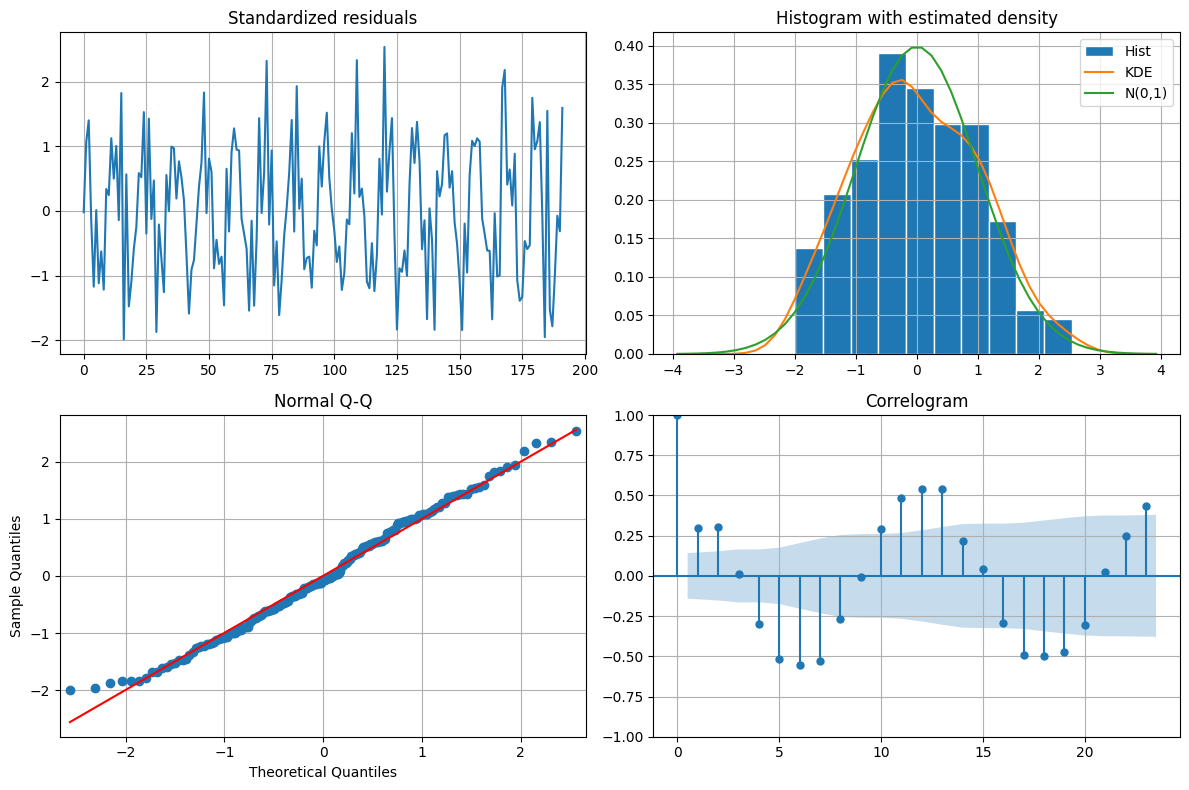

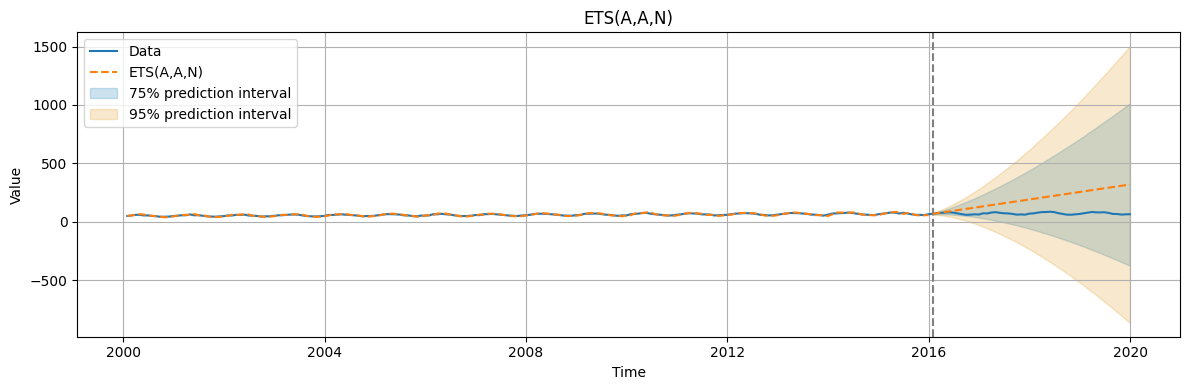

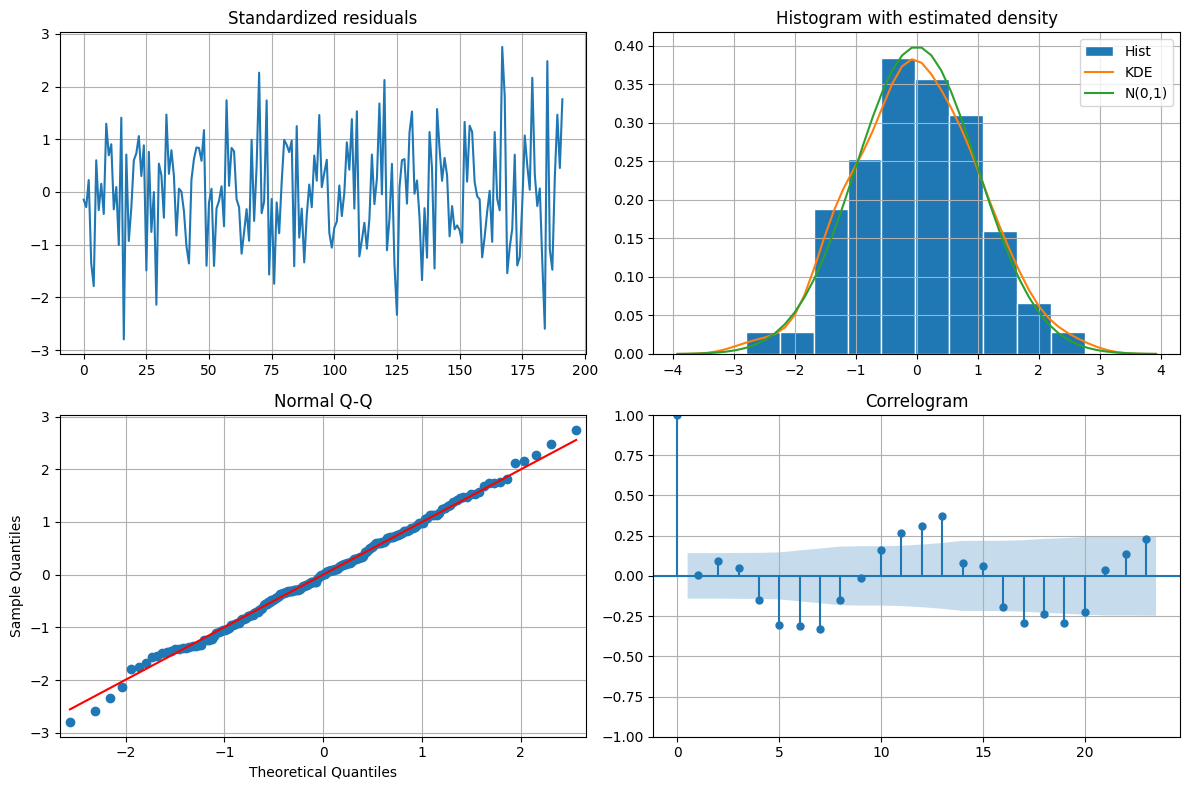

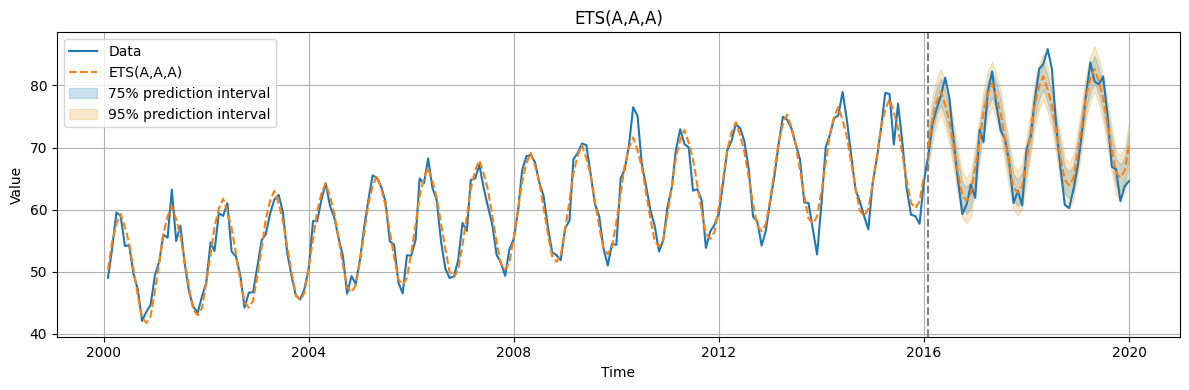

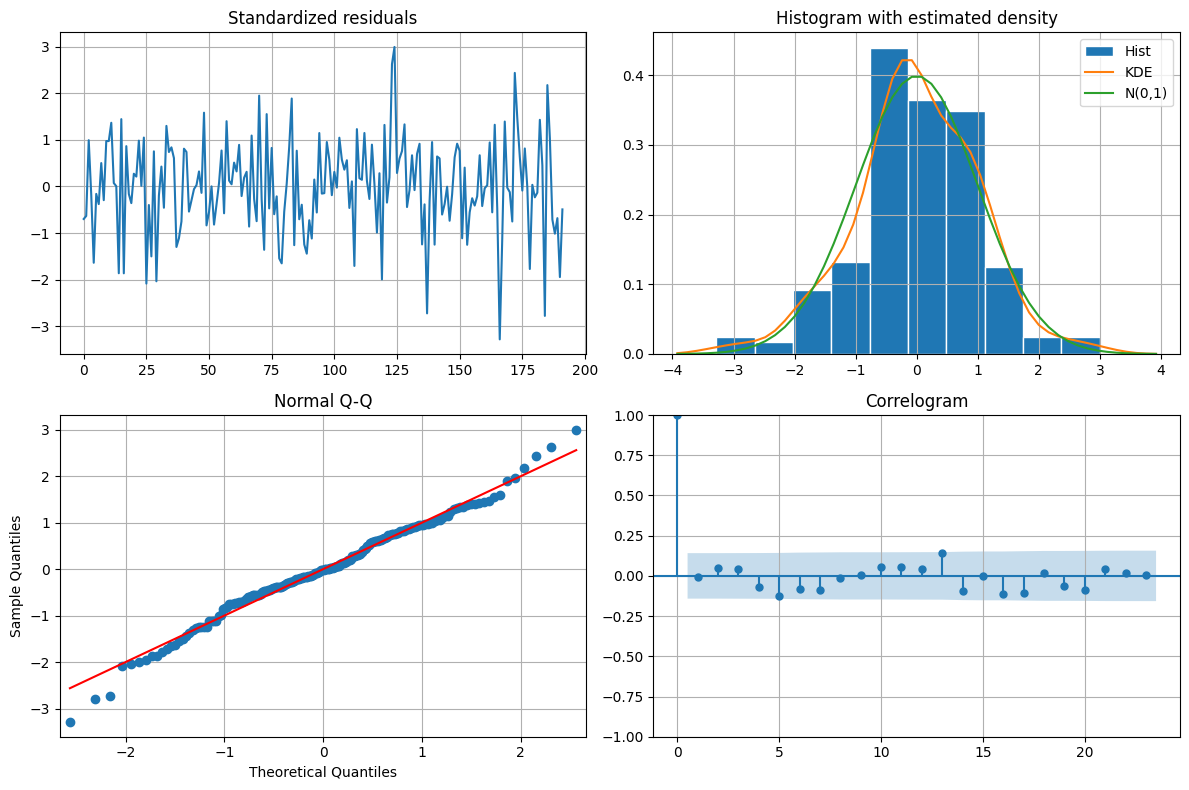

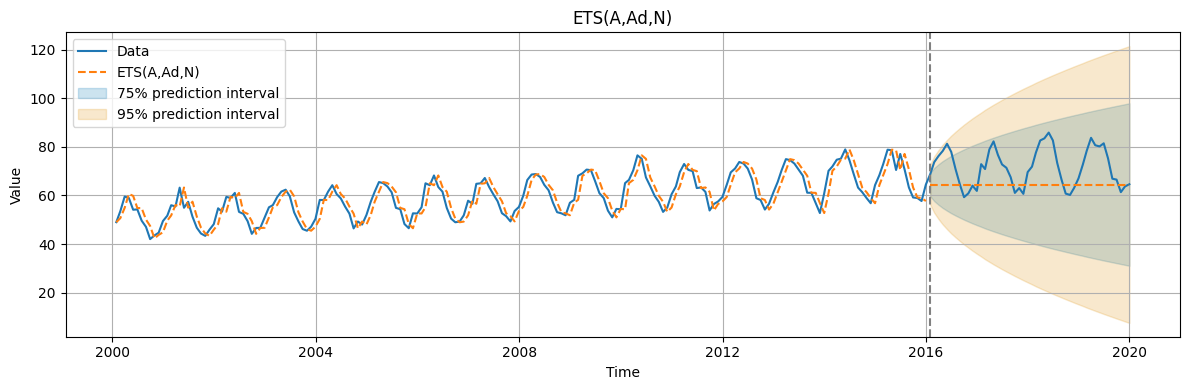

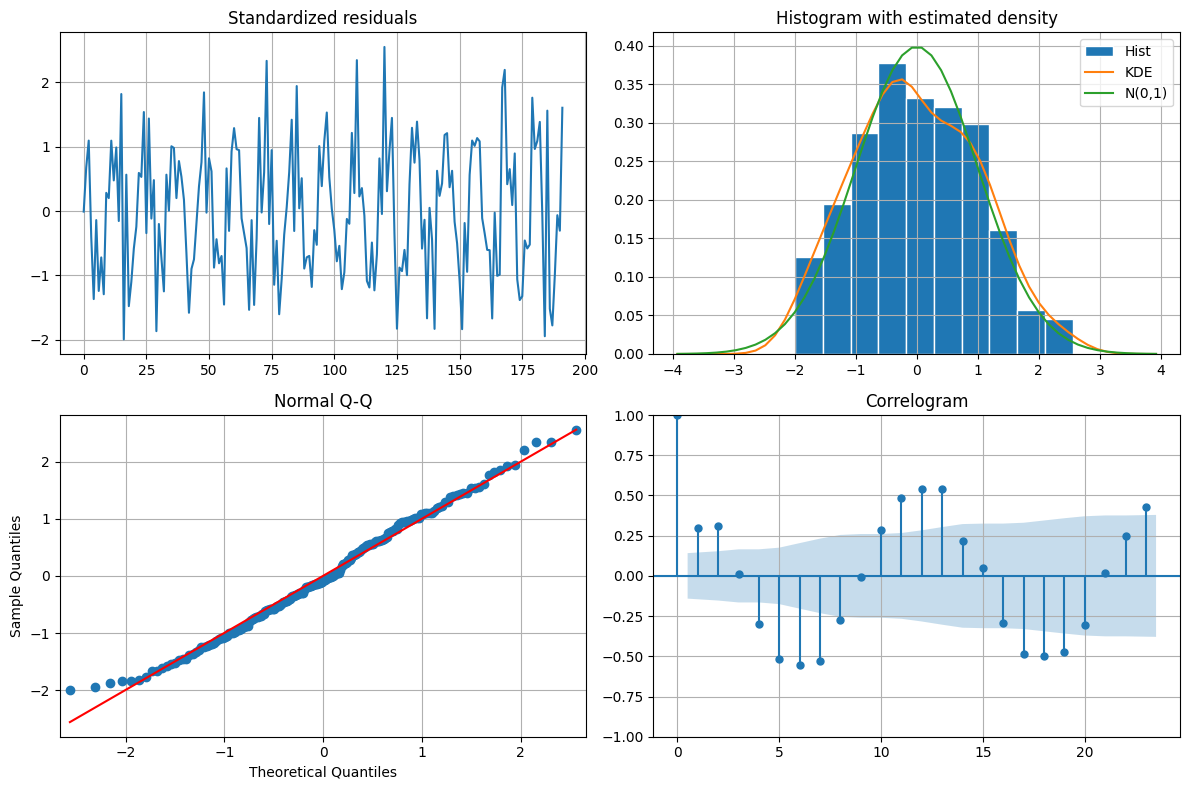

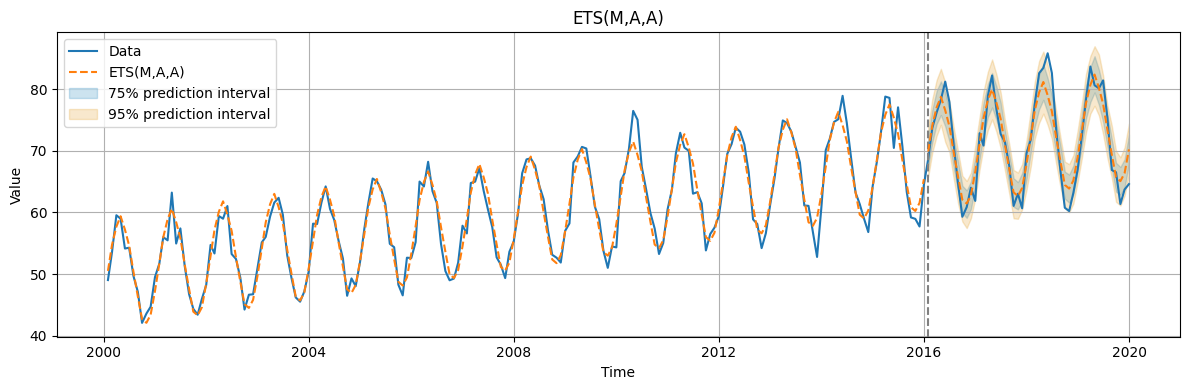

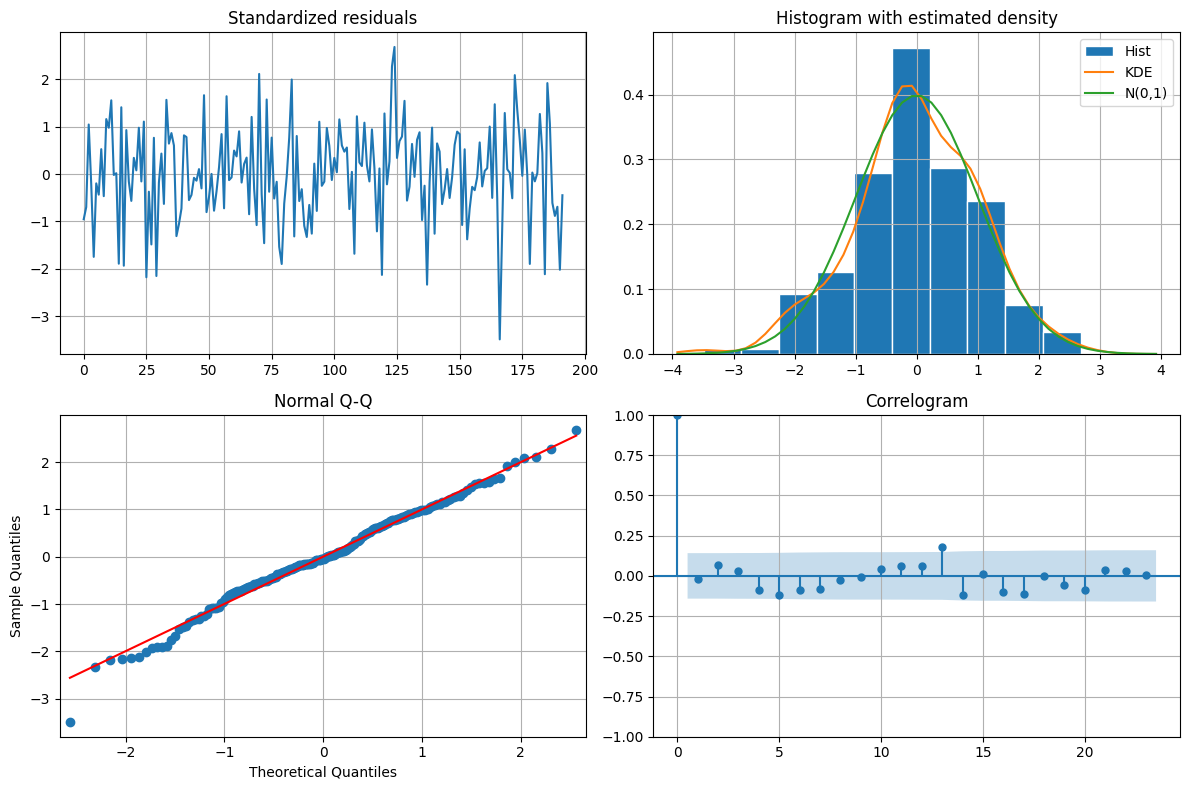

In [30]:
# run synthetic experiments
df1 = run_synth_experiment(sim_level_only_rw(seed=1), "Synthetic: random walk", period=12)
display(df1)

df2 = run_synth_experiment(sim_trend(seed=2), "Synthetic: trend", period=12)
display(df2)

df3 = run_synth_experiment(sim_trend_season_add(seed=3), "Synthetic: trend + additive seasonality", period=12)
display(df3)

df4 = run_synth_experiment(sim_multiplicative(seed=4), "Synthetic: multiplicative error pattern", period=12)
display(df4)

## ETS(A,N,N) ↔ ARIMA(0,1,1) equivalence (synthetic)

ETS alpha: 0.8685
ARIMA theta (MA1): -0.1316
alpha - 1: -0.1315


/var/folders/4b/26rq547d04x8qvf8fylq7n0c0000gn/T/ipykernel_63723/2401865667.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return pd.date_range(start, periods=n, freq=freq)  # month-end


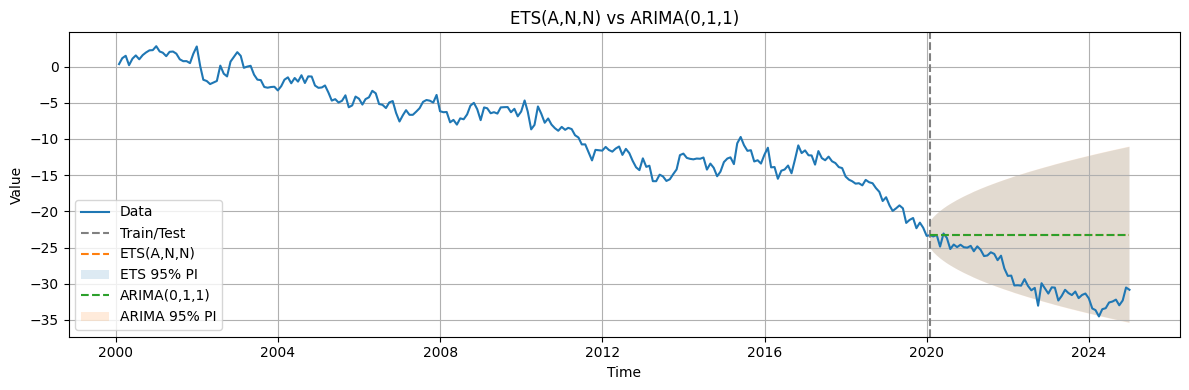

In [ ]:
def ets_ann_vs_arima_011_simple(series, train_frac=0.8):
    series_dt = series.copy()
    series_dt.index = series_dt.index.to_period("M").to_timestamp("M")

    series_ets = series_dt.to_period("M")

    n = len(series_dt)
    train_size = int(train_frac * n)
    h = n - train_size

    ets = AutoETS(error="add", trend=None, seasonal=None, auto=False).fit(series_ets.iloc[:train_size])
    ets_fc = ets.predict(fh=np.arange(1, h + 1))
    ets_pi = ets.predict_interval(fh=np.arange(1, h + 1), coverage=0.95)

    ets_fc_dt = ets_fc.copy()
    ets_fc_dt.index = ets_fc_dt.index.to_timestamp("M")
    ets_pi_dt = ets_pi.copy()
    ets_pi_dt.index = ets_pi_dt.index.to_timestamp("M")

    arima = ARIMA(series_dt.iloc[:train_size], order=(0, 1, 1),
                  enforce_stationarity=False, enforce_invertibility=False).fit()
    arima_fc = arima.get_forecast(steps=h)
    arima_mean = arima_fc.predicted_mean
    arima_ci = arima_fc.conf_int(alpha=0.05)

    fig, ax = time_plot(series_dt.index, series_dt.values, label="Data",
                        title="ETS(A,N,N) vs ARIMA(0,1,1)", xlabel="Time", ylabel="Value",
                        return_fig=True)
    ax.axvline(series_dt.index[train_size], color="gray", linestyle="--", label="Train/Test")

    ax.plot(ets_fc_dt.index, ets_fc_dt.values, linestyle="--", label="ETS(A,N,N)")
    ax.fill_between(ets_pi_dt.index, ets_pi_dt.iloc[:, 0].values, ets_pi_dt.iloc[:, 1].values,
                    alpha=0.15, label="ETS 95% PI")

    ax.plot(arima_mean.index, arima_mean.values, linestyle="--", label="ARIMA(0,1,1)")
    ax.fill_between(arima_ci.index, arima_ci.iloc[:, 0].values, arima_ci.iloc[:, 1].values,
                    alpha=0.15, label="ARIMA 95% PI")

    ax.legend()
    fig.tight_layout()

    alpha = ets._fitted_forecaster.smoothing_level
    theta = arima.params.get("ma.L1", np.nan)
    print(f"ETS alpha: {alpha:.4f}")
    print(f"ARIMA theta (MA1): {theta:.4f}")
    print(f"alpha - 1: {alpha - 1:.4f}")

    return ets, arima

s = sim_level_only_rw(seed=1)
ets_eq, arima_eq = ets_ann_vs_arima_011_simple(s)


The synthetic series is a random walk, which is the data-generating process assumed
by ETS(A,N,N). The forecasts and prediction intervals from ETS(A,N,N) and ARIMA(0,1,1)
are almost identical, confirming their theoretical equivalence.

The estimated parameters satisfy the known relationship
theta = alpha - 1, since
alpha = 0.8685 and theta = -0.1316.

In [31]:
sst_df = get_sea_surface_temp().set_index("DATE").sort_index()
sst_df.index = pd.to_datetime(sst_df.index)

# IMPORTANT: resample to monthly (month-end). Do NOT use asfreq here.
sst = sst_df["value"].resample("ME").mean()

# fill any remaining gaps
sst = sst.interpolate().ffill().bfill()

sst_p = sst.to_period("M")

full_train, (train, valid), test = split_time_series(sst_p, valid_size=0.2, test_size=0.2)

ets_candidates = [
    dict(error="add", trend=None,  seasonal=None,  sp=12, label="ETS(A,N,N)"),
    dict(error="add", trend="add", seasonal=None,  sp=12, label="ETS(A,A,N)"),
    dict(error="add", trend="add", seasonal="add", sp=12, label="ETS(A,A,A)"),
]

rows = []
y_fit = full_train.to_timestamp("M")  

for cfg in ets_candidates:
    m = AutoETS(
        error=cfg["error"],
        trend=cfg["trend"],
        seasonal=cfg["seasonal"],
        sp=cfg["sp"],
        auto=False,
    ).fit(y_fit)

    f = m._fitted_forecaster
    resid = np.asarray(f.resid)
    lb = acorr_ljungbox(resid, lags=[24], return_df=True)["lb_pvalue"].iloc[0]

    rows.append({
        "model": cfg["label"],
        "AIC": f.aic,
        "BIC": f.bic,
        "LB_p(24)": lb
    })

res_df = pd.DataFrame(rows).sort_values("AIC")
display(res_df)

best_label = res_df.iloc[0]["model"]
best_cfg = next(c for c in ets_candidates if c["label"] == best_label)
print("Best by AIC:", best_label)

model          AIC          BIC  LB_p(24)
2  ETS(A,A,A)   726.182316   804.871329  0.000364
0  ETS(A,N,N)  1807.194307  1820.309142  0.000000
1  ETS(A,A,N)  1811.248428  1833.106487  0.000000

Best by AIC: ETS(A,A,A)


The ETS(A,A,A) model has the lowest AIC and BIC among the considered candidates,
indicating the best trade-off between goodness of fit and model complexity.

The very small Ljung–Box p-value for all models suggests remaining autocorrelation
in the residuals, but ETS(A,A,A) clearly improves the fit compared to models without
trend or seasonality.

Therefore, ETS(A,A,A) is selected as the preferred model for the SST series.

## Residual analysis for best ETS

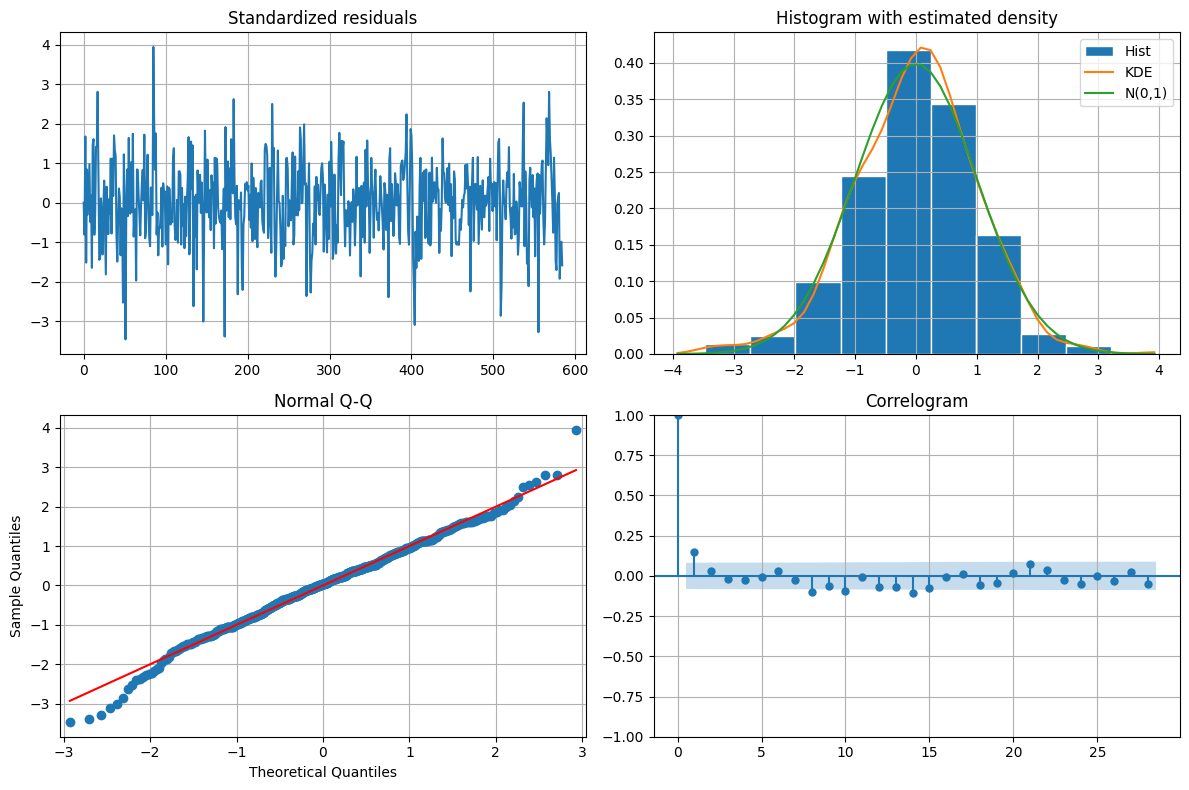

In [32]:
best_ets = AutoETS(error=best_cfg["error"], trend=best_cfg["trend"], seasonal=best_cfg["seasonal"], sp=12, auto=False).fit(full_train)
resid = np.asarray(best_ets._fitted_forecaster.resid)
std_resid = (resid - resid.mean()) / (resid.std(ddof=1) + 1e-12)
residual_analysis_plots(std_resid)


The standardized residuals fluctuate around zero with approximately constant variance,
indicating no obvious bias.

The histogram and Q–Q plot show that the residuals are close to normally distributed,
with only minor deviations in the tails.

The correlogram shows no significant autocorrelation, suggesting that the residuals
behave like white noise.

Overall, the diagnostic plots indicate that the ETS(A,A,A) model provides an adequate
fit to the SST data.

In [24]:
fh = ForecastingHorizon([1], is_relative=True)

ets_model = AutoETS(
    error=best_cfg["error"],
    trend=best_cfg["trend"],
    seasonal=best_cfg["seasonal"],
    sp=12,
    auto=False
)

_ = evaluate_forecaster(ets_model, train, valid, fh=fh, is_test=False)


Evaluating AutoETS: validation split divided into 117 cv folds
AutoETS validation MeanSquaredError: 0.342 ± 0.295
AutoETS validation MeanAbsoluteError: 0.342 ± 0.295


Using expanding-window cross-validation with 1-step-ahead forecasts (117 folds),
AutoETS achieves RMSE ≈ 0.342 and MAE ≈ 0.342. The standard deviations (≈ 0.295)
show that forecast errors vary over time, but the average performance is stable.

## Cross-validation performance (arima)

In [ ]:

sst_arima = sst.copy()
sst_arima.index = sst_arima.index.to_period("M").to_timestamp("M") 
sst_arima.index.freq = "M"
sst_ets = sst_arima.to_period("M")

order = (0, 1, 1)
seasonal_order = (0, 1, 0, 12)

def rolling_rmse(series_ets, series_arima, ets_cfg, arima_order, arima_seasonal, initial_train_size):
    errors_ets, errors_arima = [], []
    for end in range(initial_train_size, len(series_ets)):
        train_ets = series_ets.iloc[:end]
        train_arima = series_arima.iloc[:end]
        actual = series_arima.iloc[end]

        ets = AutoETS(error=ets_cfg["error"], trend=ets_cfg["trend"], seasonal=ets_cfg["seasonal"], sp=ets_cfg["sp"], auto=False).fit(train_ets)
        ets_pred = ets.predict(fh=[1]).iloc[0]
        errors_ets.append(actual - ets_pred)

        arima = SARIMAX(train_arima, order=arima_order, seasonal_order=arima_seasonal,
                        enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        arima_pred = arima.get_forecast(steps=1).predicted_mean.iloc[0]
        errors_arima.append(actual - arima_pred)

    return sqrt(np.mean(np.square(errors_ets))), sqrt(np.mean(np.square(errors_arima)))

best_cfg_roll = dict(best_cfg) | {"sp": 12}
initial_train = int(0.7 * len(sst_ets))
rmse_ets, rmse_arima = rolling_rmse(sst_ets, sst_arima, best_cfg_roll, order, seasonal_order, initial_train)

print(f"Rolling 1-step RMSE – ETS  : {rmse_ets:.3f}")
print(f"Rolling 1-step RMSE – ARIMA: {rmse_arima:.3f}")


/var/folders/4b/26rq547d04x8qvf8fylq7n0c0000gn/T/ipykernel_63723/1291137908.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sst_arima.index.freq = "M"


Rolling 1-step RMSE – ETS  : 0.482
Rolling 1-step RMSE – ARIMA: 0.653


The models are compared using rolling one-step-ahead forecasts.
At each time step, the model is refitted and used to predict the next observation.

The resulting RMSE values are:
- ETS: 0.482  
- ARIMA: 0.653  

The lower RMSE of ETS indicates that it provides more accurate short-term forecasts
than ARIMA for the sea surface temperature series.

## Forecast + 95% prediction intervals: ETS vs ARIMA

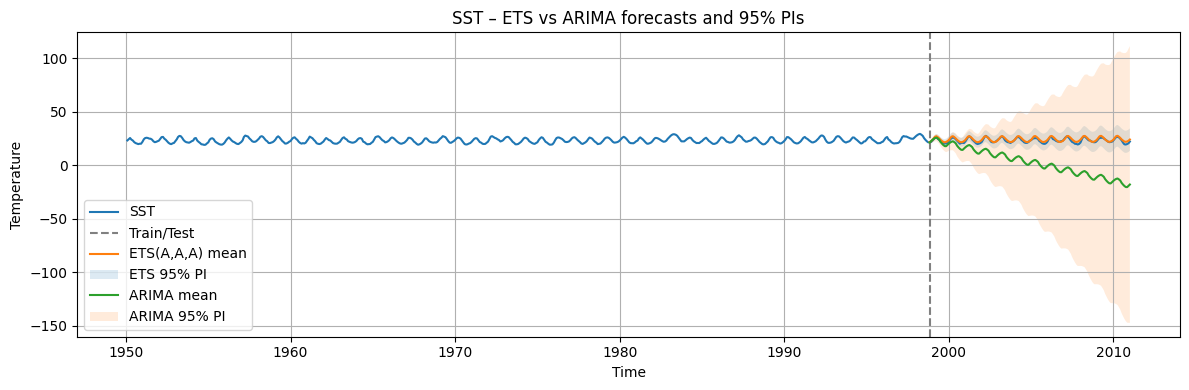

In [ ]:
train_size = int(0.8 * len(sst_arima))
train_dt = sst_arima.iloc[:train_size]
test_dt = sst_arima.iloc[train_size:]

# ETS
ets_final = AutoETS(error=best_cfg["error"], trend=best_cfg["trend"], seasonal=best_cfg["seasonal"], sp=12, auto=False).fit(train_dt.to_period("M"))
fh = np.arange(1, len(test_dt) + 1)
ets_fc = ets_final.predict(fh=fh)
ets_pi = ets_final.predict_interval(fh=fh, coverage=0.95)
ets_fc_dt = ets_fc.copy(); ets_fc_dt.index = test_dt.index
ets_pi_dt = ets_pi.copy(); ets_pi_dt.index = test_dt.index

# ARIMA
arima_final = SARIMAX(train_dt, order=order, seasonal_order=seasonal_order, enforce_stationarity=False).fit(disp=False)
arima_fc = arima_final.get_forecast(steps=len(test_dt))
arima_mean = arima_fc.predicted_mean
arima_ci = arima_fc.conf_int(alpha=0.05)

# Plot
fig, ax = time_plot(sst_arima.index, sst_arima.values, label="SST",
                    title="SST – ETS vs ARIMA forecasts and 95% PIs",
                    xlabel="Time", ylabel="Temperature", return_fig=True)
ax.axvline(test_dt.index[0], color="gray", linestyle="--", label="Train/Test")

ax.plot(test_dt.index, ets_fc_dt.values, label=f"{best_label} mean")
ax.fill_between(test_dt.index, ets_pi_dt.iloc[:, 0].values, ets_pi_dt.iloc[:, 1].values, alpha=0.15, label="ETS 95% PI")

ax.plot(test_dt.index, arima_mean.values, label="ARIMA mean")
ax.fill_between(test_dt.index, arima_ci.iloc[:, 0].values, arima_ci.iloc[:, 1].values, alpha=0.15, label="ARIMA 95% PI")

ax.legend()
fig.tight_layout()


The figure compares forecasts for sea surface temperature using
ETS(A,A,A) and ARIMA, together with 95% prediction intervals.

Both models produce similar point forecasts.
However, the ARIMA forecast quickly drifts downward and its prediction interval
widens rapidly, indicating increasing uncertainty and instability at longer horizons.

In contrast, the ETS model produces a stable forecast that preserves the seasonal
pattern and has much narrower prediction intervals. This suggests that ETS provides
more reliable and realistic long-term forecasts for this series.

## Decomposition (STL) to compare with ETS components

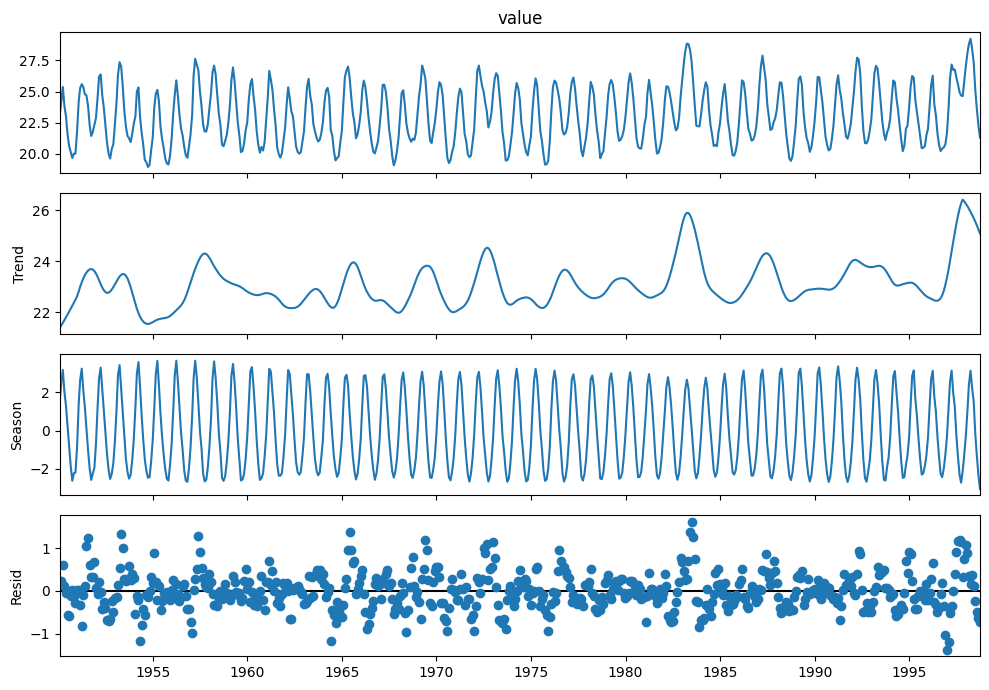

In [33]:
y = full_train.to_timestamp("M")
stl = STL(y, period=12).fit()
fig = stl.plot()
fig.set_size_inches(10, 7)
fig.tight_layout()

The STL decomposition is applied to the sea surface temperature data to separate
trend, seasonality, and noise.

The decomposition shows a clear annual seasonal pattern and a smooth trend,
which matches the structure assumed by the ETS(A,A,A) model.
The residuals are small and centered around zero, indicating that most variation
in the SST data is explained by trend and seasonality.